In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Downloading locally
- The easiest way to install diad fit is by removing the #, and running this once per computer. When I update the code, you'll need to get the new tag off GitHub:
https://github.com/PennyWieser/DiadFit/tags
Right click on the top one, over the 'zip' icon, click copy link address
- If youve already done this for Ne, you dont need to do here too

In [2]:
#!pip install --upgrade "https://github.com/PennyWieser/DiadFit/archive/refs/tags/0.0.11.zip"

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [3]:
import DiadFit as pf
pf.__version__

'0.0.19'

In [4]:
# Add the path with your spectra in
mypath=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Shifting_Window_VIBE\Spectra'

In [5]:
# This specifies what file type your Raman exported in. 
filetype='headless_txt'
# Specifying the extension here helps to filter out other file types,
# e.g. png files that may be in the folder
file_ext='.txt'
# If your instrument appends a nubmer like 01, 02 to each file, prefix=True removes it
prefix=False

## This function finds all files in your path with the specified file format
- As you will fit your Ne lines in a different workbook, you can use 'exclude_str' to put any text that appears in all your Ne files, and it won't look here

In [6]:
Diad_files=pf.get_diad_files(path=mypath, file_ext=file_ext, exclude_str='Ne',
                            exclude_str_2='ne')
Diad_files

exclude type
.png


['Fo1-1185down.txt',
 'Fo1-1200down.txt',
 'Fo1-1200up.txt',
 'Fo1-1225down.txt',
 'Fo1-1225up.txt',
 'Fo1-1250up.txt',
 'Fo1-1300down.txt',
 'Fo1-1300up.txt',
 'Fo1-1325down.txt',
 'Fo1-1325up.txt']

In [7]:
help(pf.get_diad_files)

Help on function get_diad_files in module DiadFit.importing_data_files:

get_diad_files(path, sort=True, file_ext='txt', exclude_str='Ne', exclude_str_2='ne', exclude_type='.png')
    This function takes a user path, and extracts all files which dont contain the excluded string and type
    
    Parameters
    -----------
    
    path: str
        Folder user wishes to read data from
    sort: bool
        If true, sorts files alphabetically
    file_ext: str
        File format. Default txt, could also enter csv etc.
    exclude_str: str
        Excludes files with this string in their name. E.g. if exclude_str='Ne' it will exclude Ne lines
    exclude_type: str
        Excludes files of this type, e.g. exclude_type='png' gets rid of image files.
    
    Returns
    -----------
    Returns file names as a list.



## Select the first file you want to fit
- This allows you to tweak parameters for your spectra and your instrument

In [8]:
filename=Diad_files[0] # This finds the first file

# Alternatively, you can specify the actual file name if you want to fit a specific one
#filename='007_k9.csv'
print(filename)

Fo1-1185down.txt


## First we plot the spectra
- This lets you look at the spectra, decide how strong your hotbands are, and see how elevated the diads are (if they are very elevated, you may need to fit a gaussian background too)

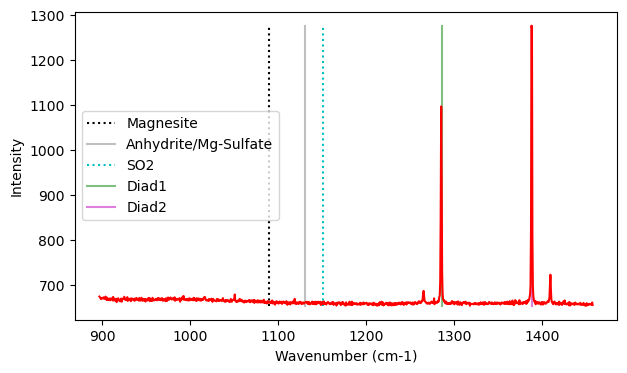

In [9]:
pf.plot_diad(path=mypath, filename=filename, filetype=filetype)

## After inspecting the spectra, decide if you want to fit the carbonate peak
- First, look at the presets, you can edit them in carb_peak_config by typing the variable name, and a new value

In [10]:
# Decide if you want to fit a carbonate peak or not here. 
fit_carbonate=False

# Tweak options here, can exclude a range for example using exclude_range=Tuple[float, float]
Carb_Config=pf.carb_peak_config(lower_bck=(1060, 1065), upper_bck=(1120, 1330))
Carb_Config   

carb_peak_config(lower_bck=(1060, 1065), upper_bck=(1120, 1330), N_poly_carb_bck=1, amplitude=1000, cent_carbonate=1090, outlier_sigma=12, N_peaks=3, distance=10, prominence=5, width=6, threshold=0.1, exclude_range=None, dpi=100, plot_figure=True)

## This actually does the work fitting the carbonate peak

In [11]:
Carb_fit=pf.fit_carbonate_peak(config=Carb_Config, path=mypath, 
filename=filename, filetype=filetype,
fit_carbonate=fit_carbonate)
Carb_fit

## Now lets plot the diads
- As with carbonate, you can exclude 2 segments (e.g. around cosmic rays)
- You then specify how many peaks you want to fit on each diad. 1 means just the strong peak, 2 hotbands, and 3 for Diad2 would also fit the C13 peak if present. 
- The identify_diad_peaks then uses scipy findpeaks to identify the positions of the 2 diads, and any other peaks the user asks for. These are saved, and fed into the later functions for peak fitting. 

In [12]:
diad_id_config=pf.diad_id_config()
diad_id_config

diad_id_config(exclude_range1=None, exclude_range2=None, approx_diad2_pos=(1379, 1385), approx_diad1_pos=(1275, 1280), height=400, distance=5, threshold=0.5, width=0.5, prominence=10, plot_figure=True)

Initial estimates: Diad1+HB=[1277.5], Diad2+HB=[1382.]


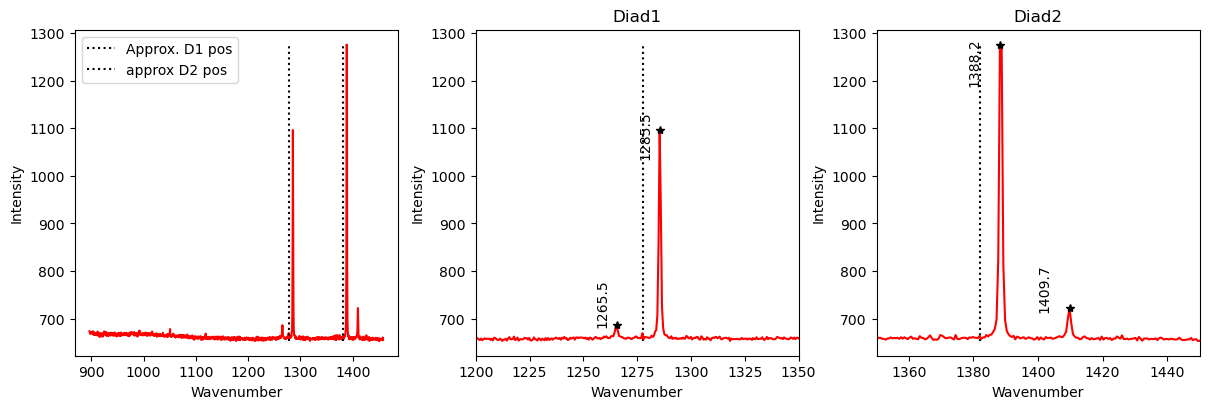

In [13]:
# Specify the number of peaks, 1 = just peak, 2 = Peak+hot bands
n_peaks_diad1=2
n_peaks_diad2=2 

    
diad1_peaks, diad2_peaks=pf.identify_diad_peaks(config=diad_id_config, path=mypath, filename=filename,
filetype=filetype, n_peaks_diad1=n_peaks_diad1, n_peaks_diad2=n_peaks_diad2)

In [14]:
type(diad1_peaks)

numpy.ndarray

## If you have no diads visible...
- change True to False, and it will just save the carbonate peak parameters

In [15]:
diads_present=True
pf.proceed_to_fit_diads(filename, Carb_fit, diads_present=diads_present)

Move on to fit diads


## Fit Diad 1
- This function uses the guess of the peak parameters above. 
- For very dense diads, you may need to fit a gaussian background, defined by peak_pos_gauss=None, gauss_sigma=1, gauss_amp=3000
- Otherwise, the background is fitted with a polynomial you can set the degree for (Default =1) based on background positoins defined by lower_bck, upper_bck...
- If plot_figure=True, it saves the figure in its own folder in the path, so you can inspect all the fits at a later date. 

In [16]:
diad1_fit_config=pf.diad1_fit_config(x_range_residual=10, x_range_baseline=10,
                                    HB_amplitude=5, diad_amplitude=100)
diad1_fit_config

diad1_fit_config(peak_pos_gauss=None, gauss_sigma=1, gauss_amp=3000, N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220), upper_bck_diad1=(1300, 1350), diad_amplitude=100, HB_amplitude=5, x_range_baseline=10, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=10, return_other_params=False)

Making summary figure of different fits for saving


Diad1_Cent  Diad1_Area  Residual_Diad1
0  1285.530908  651.639693        2.570361

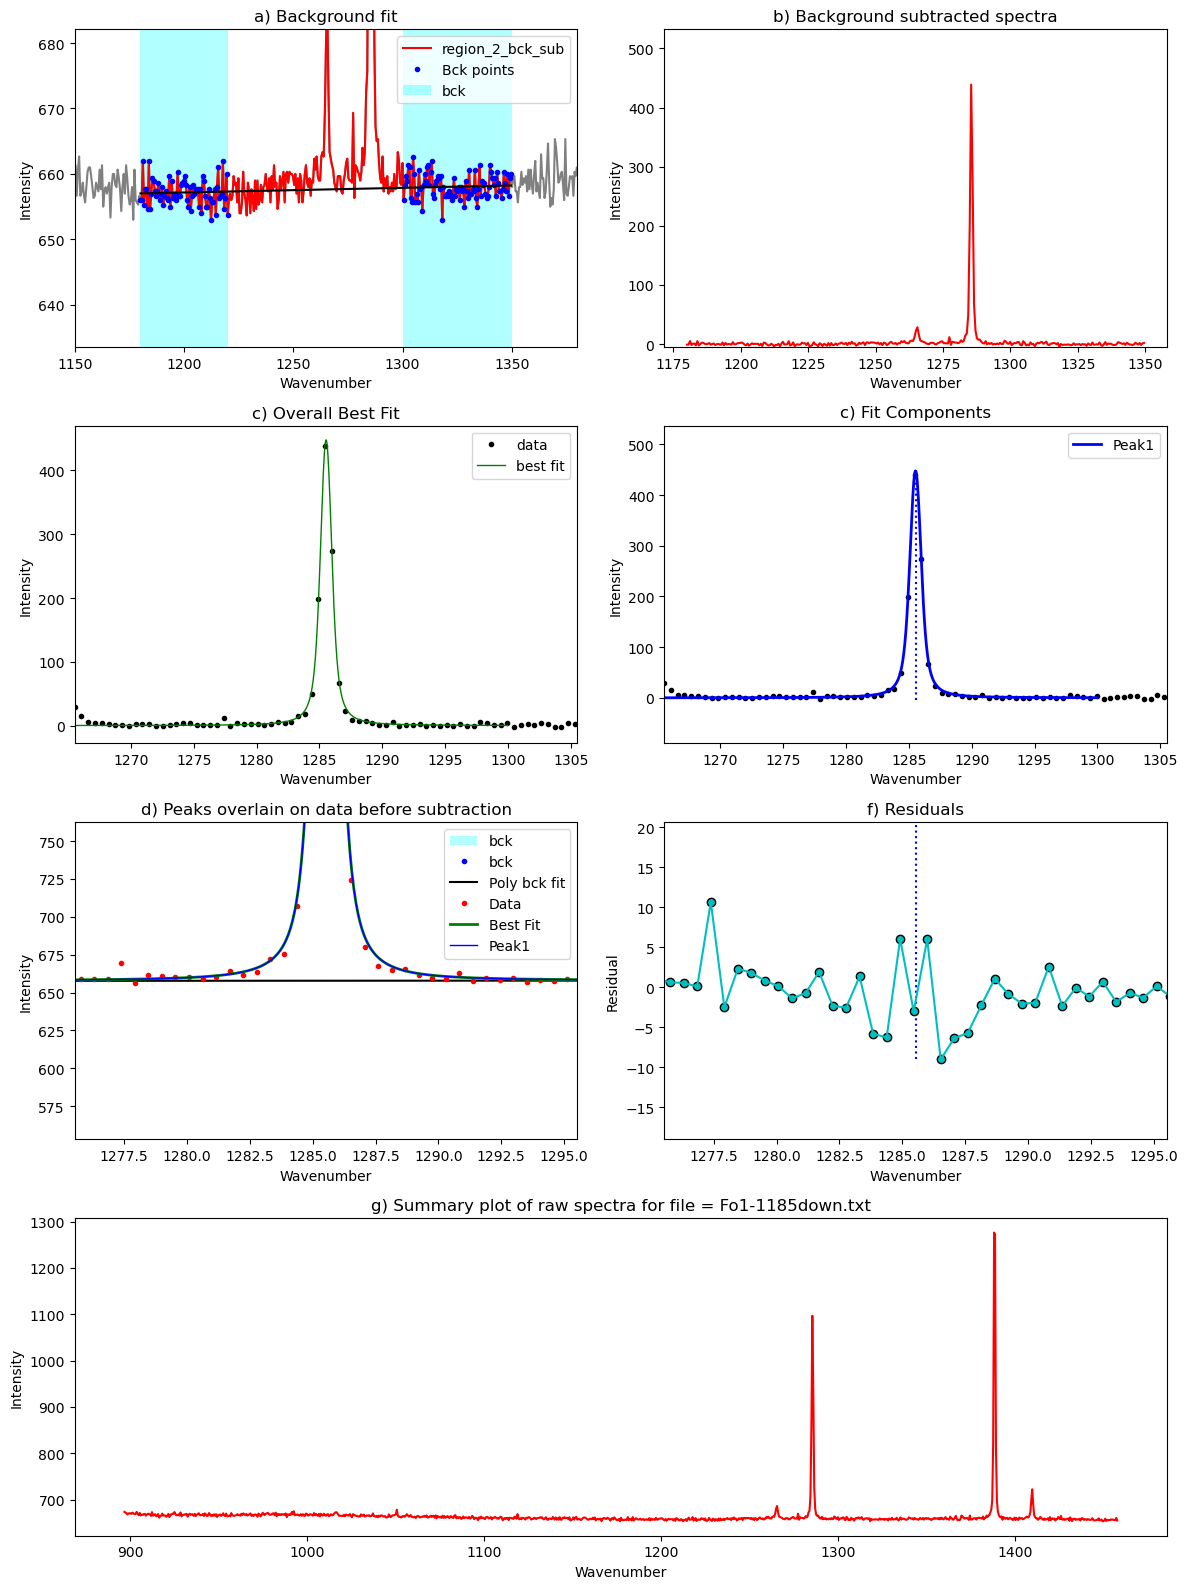

In [17]:
# For very dense spectra, with a very elevated background, you'll need to add a gaussian fit
# If you put a number in brackets, it'll center a gaussian extra background near there. 

# Do you want to save the figure?
plot_figure=True
# This function does the work fitting the diad
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad1_peaks,
path=mypath, filename=filename, filetype=filetype)
Diad1_fit

## Fit diad 2

In [18]:
diad2_fit_config=pf.diad2_fit_config(x_range_residual=10, x_range_baseline=10)
diad2_fit_config

diad2_fit_config(peak_pos_gauss=None, gauss_sigma=1, gauss_amp=3000, N_poly_bck_diad2=1, lower_bck_diad2=(1300, 1360), upper_bck_diad2=(1440, 1470), diad_amplitude=100, HB_amplitude=20, x_range_baseline=10, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=10, return_other_params=False)

1388.4517944485567
<Parameter 'sigma', value=0.258303218103082 +/- 0.00375, bounds=[0:inf]>
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'Residual_Diad2'], dtype='object')


Diad2_Cent  Diad2_Area  Residual_Diad2
0  1388.451794  969.253392        3.306793

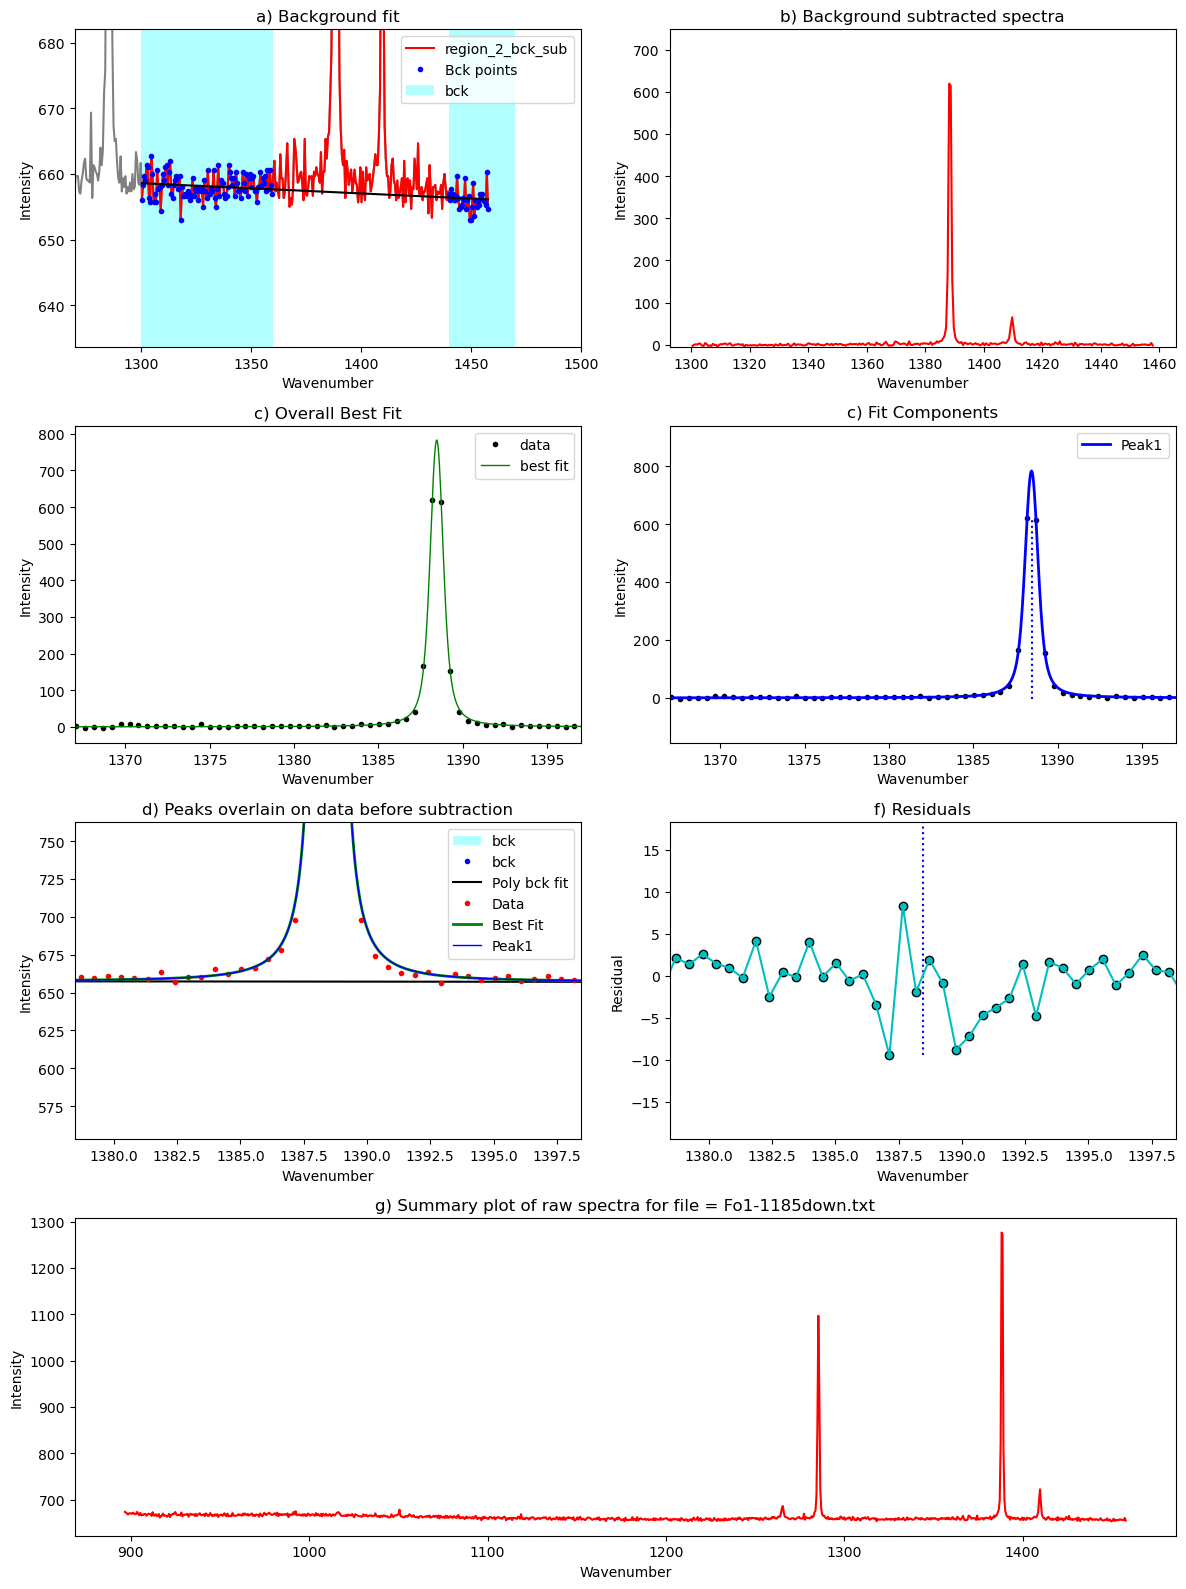

In [19]:
# Do you want to save the figure?
plot_figure=True
# This function does the work fitting the diad
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad2_peaks,
path=mypath, filename=filename, filetype=filetype)
Diad2_fit

## Combine and save
- Saves to clipboard if to_clipboard=True (e.g. you can paste into a spreadsheet)
- Also saves to 'csv' in a folder in "mypath" if to_csv=True)
- It also makes a new 

In [20]:
out=pf.combine_diad_outputs(filename=filename, prefix=prefix, 
Diad1_fit=Diad1_fit, to_clipboard=True, to_csv=True, path=mypath,
Diad2_fit=Diad2_fit, Carb_fit=Carb_fit)
out

filename   Splitting   Diad1_Cent  Diad1_Area  Residual_Diad1  \
0  Fo1-1185down  102.920886  1285.530908  651.639693        2.570361   

    Diad2_Cent  Diad2_Area  Residual_Diad2  HB1_Cent  HB1_Area  HB2_Cent  \
0  1388.451794  969.253392        3.306793       NaN         0       NaN   

   HB2_Area  C13_Cent  C13_Area  
0         0       NaN         0

In [21]:
out

filename   Splitting   Diad1_Cent  Diad1_Area  Residual_Diad1  \
0  Fo1-1185down  102.920886  1285.530908  651.639693        2.570361   

    Diad2_Cent  Diad2_Area  Residual_Diad2  HB1_Cent  HB1_Area  HB2_Cent  \
0  1388.451794  969.253392        3.306793       NaN         0       NaN   

   HB2_Area  C13_Cent  C13_Area  
0         0       NaN         0

## You can also try looping if all your spectra are pretty similar

working on Fo1-1185down.txt
1388.4517944485567
<Parameter 'sigma', value=0.258303218103082 +/- 0.00375, bounds=[0:inf]>
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_16844\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on Fo1-1200down.txt
1388.4111983815683
<Parameter 'sigma', value=0.26924337794451536 +/- 0.0029, bounds=[0:inf]>
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_16844\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on Fo1-1200up.txt
1388.4080955047941
<Parameter 'sigma', value=0.2680772822772064 +/- 0.00277, bounds=[0:inf]>
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_16844\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on Fo1-1225down.txt
1388.45820166119
<Parameter 'sigma', value=0.2652952382186595 +/- 0.00313, bounds=[0:inf]>
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_16844\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on Fo1-1225up.txt
1388.4511507709715
<Parameter 'sigma', value=0.25550506120390826 +/- 0.00267, bounds=[0:inf]>
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_16844\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on Fo1-1250up.txt
1388.4022138144621
<Parameter 'sigma', value=0.2578644804086381 +/- 0.0031, bounds=[0:inf]>
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_16844\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on Fo1-1300down.txt
1388.4722411737398
<Parameter 'sigma', value=0.2554416878233281 +/- 0.00322, bounds=[0:inf]>
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_16844\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on Fo1-1300up.txt
1388.402439819724
<Parameter 'sigma', value=0.0005564963201138973 +/- 2.66, bounds=[0:inf]>
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_16844\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on Fo1-1325down.txt
1388.5315927568267
<Parameter 'sigma', value=0.2625287753675931 +/- 0.00219, bounds=[0:inf]>
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_16844\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


working on Fo1-1325up.txt
1388.3947560496347
<Parameter 'sigma', value=0.26312781546004427 +/- 0.00245, bounds=[0:inf]>
Making summary figure of different fits for saving
Index(['Diad2_Cent', 'Diad2_Area', 'Residual_Diad2'], dtype='object')
Making summary figure of different fits for saving


C:\Users\penny\AppData\Local\Temp\ipykernel_16844\899996927.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


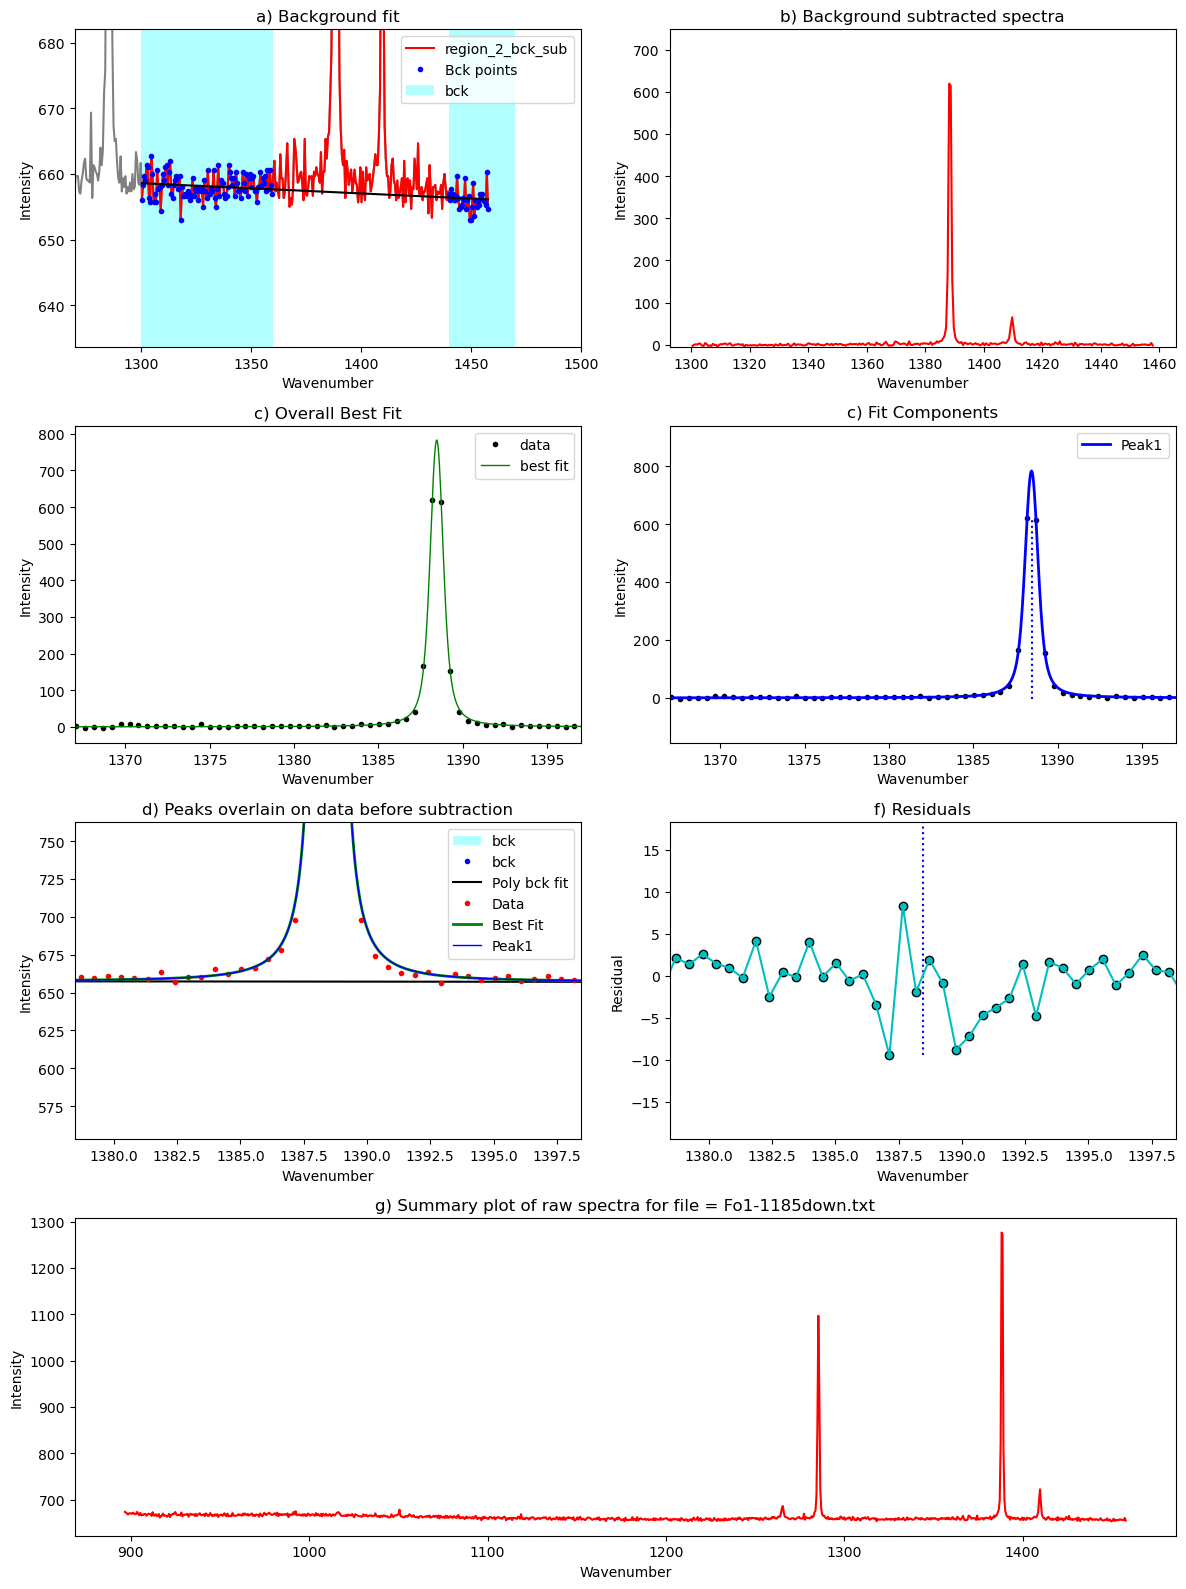

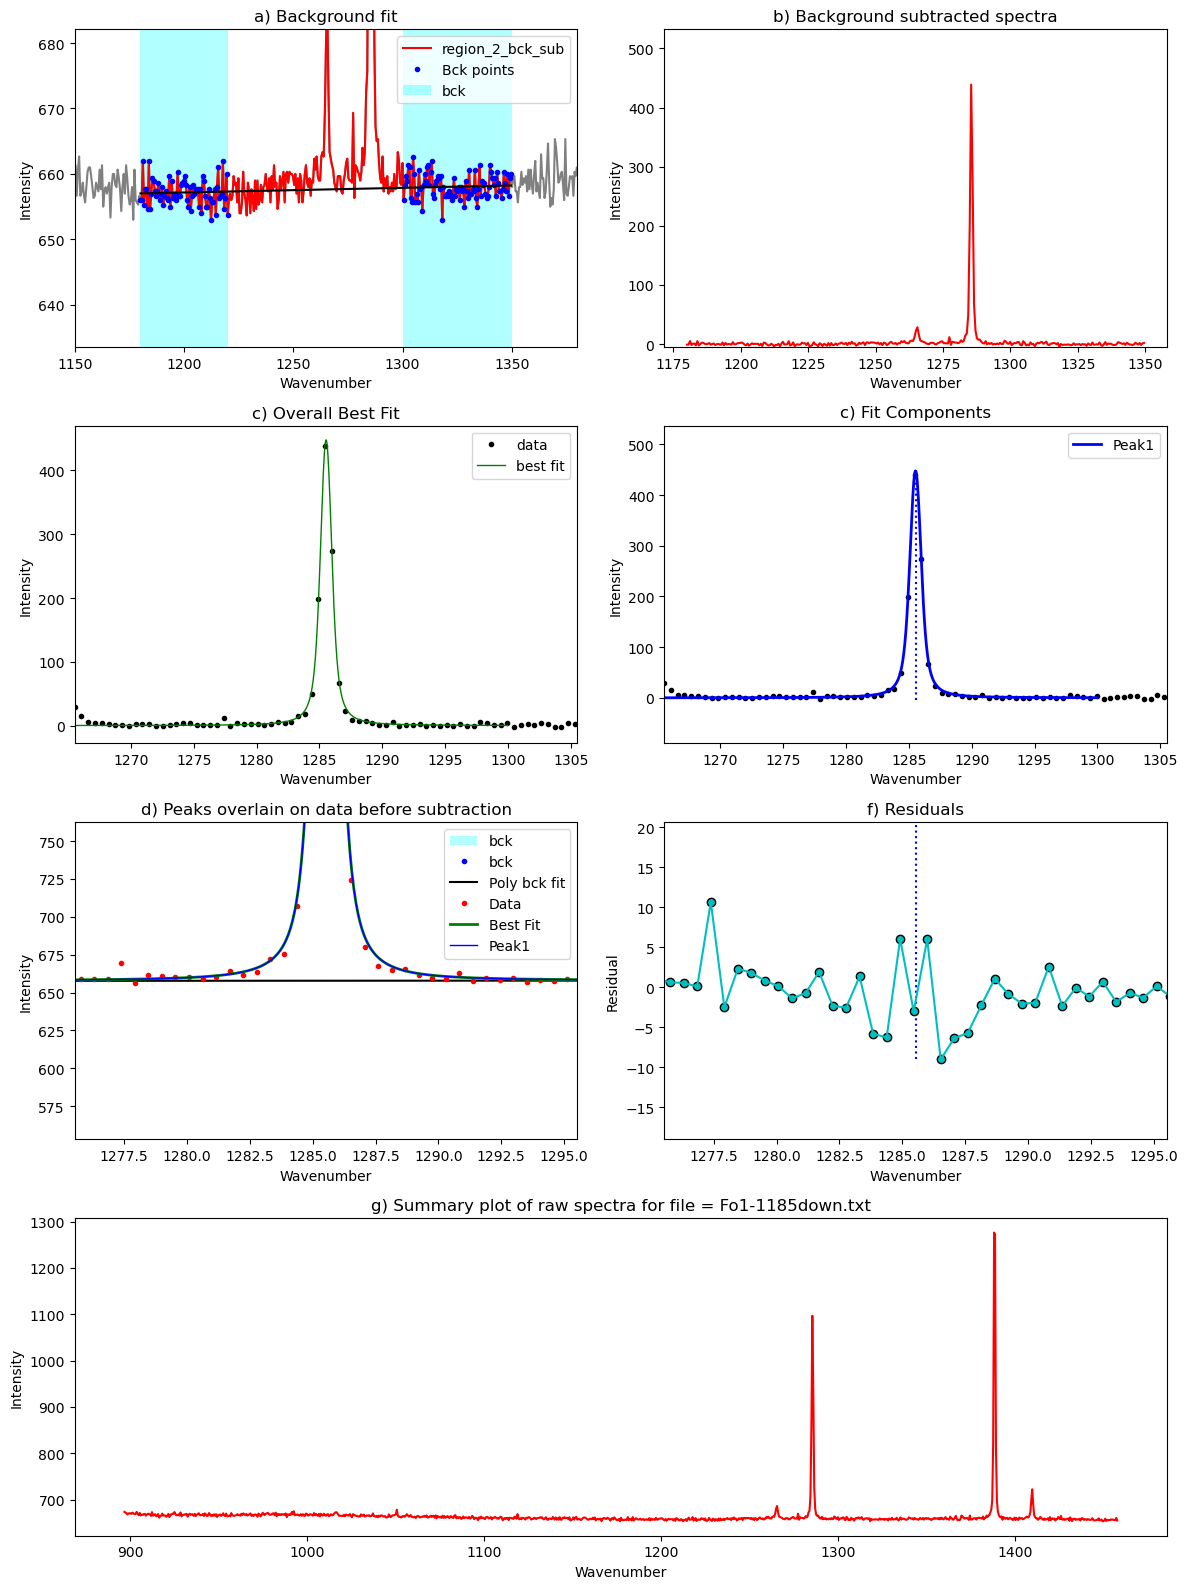

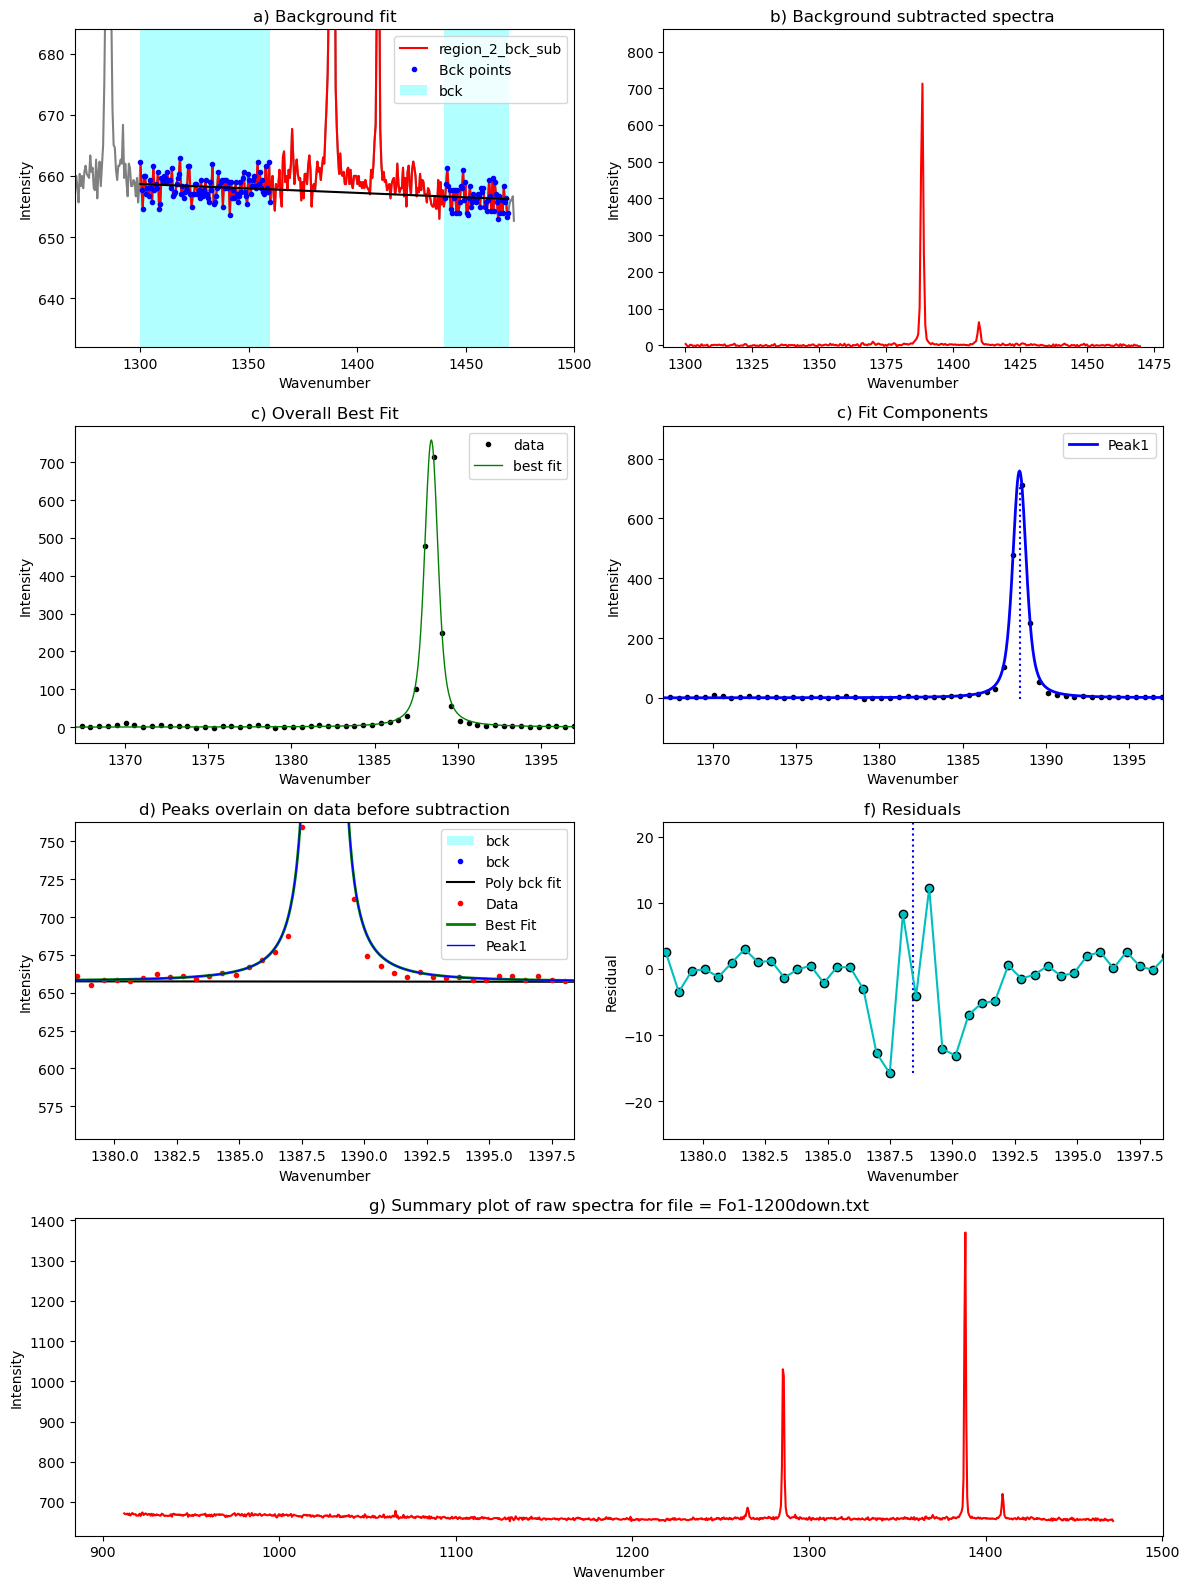

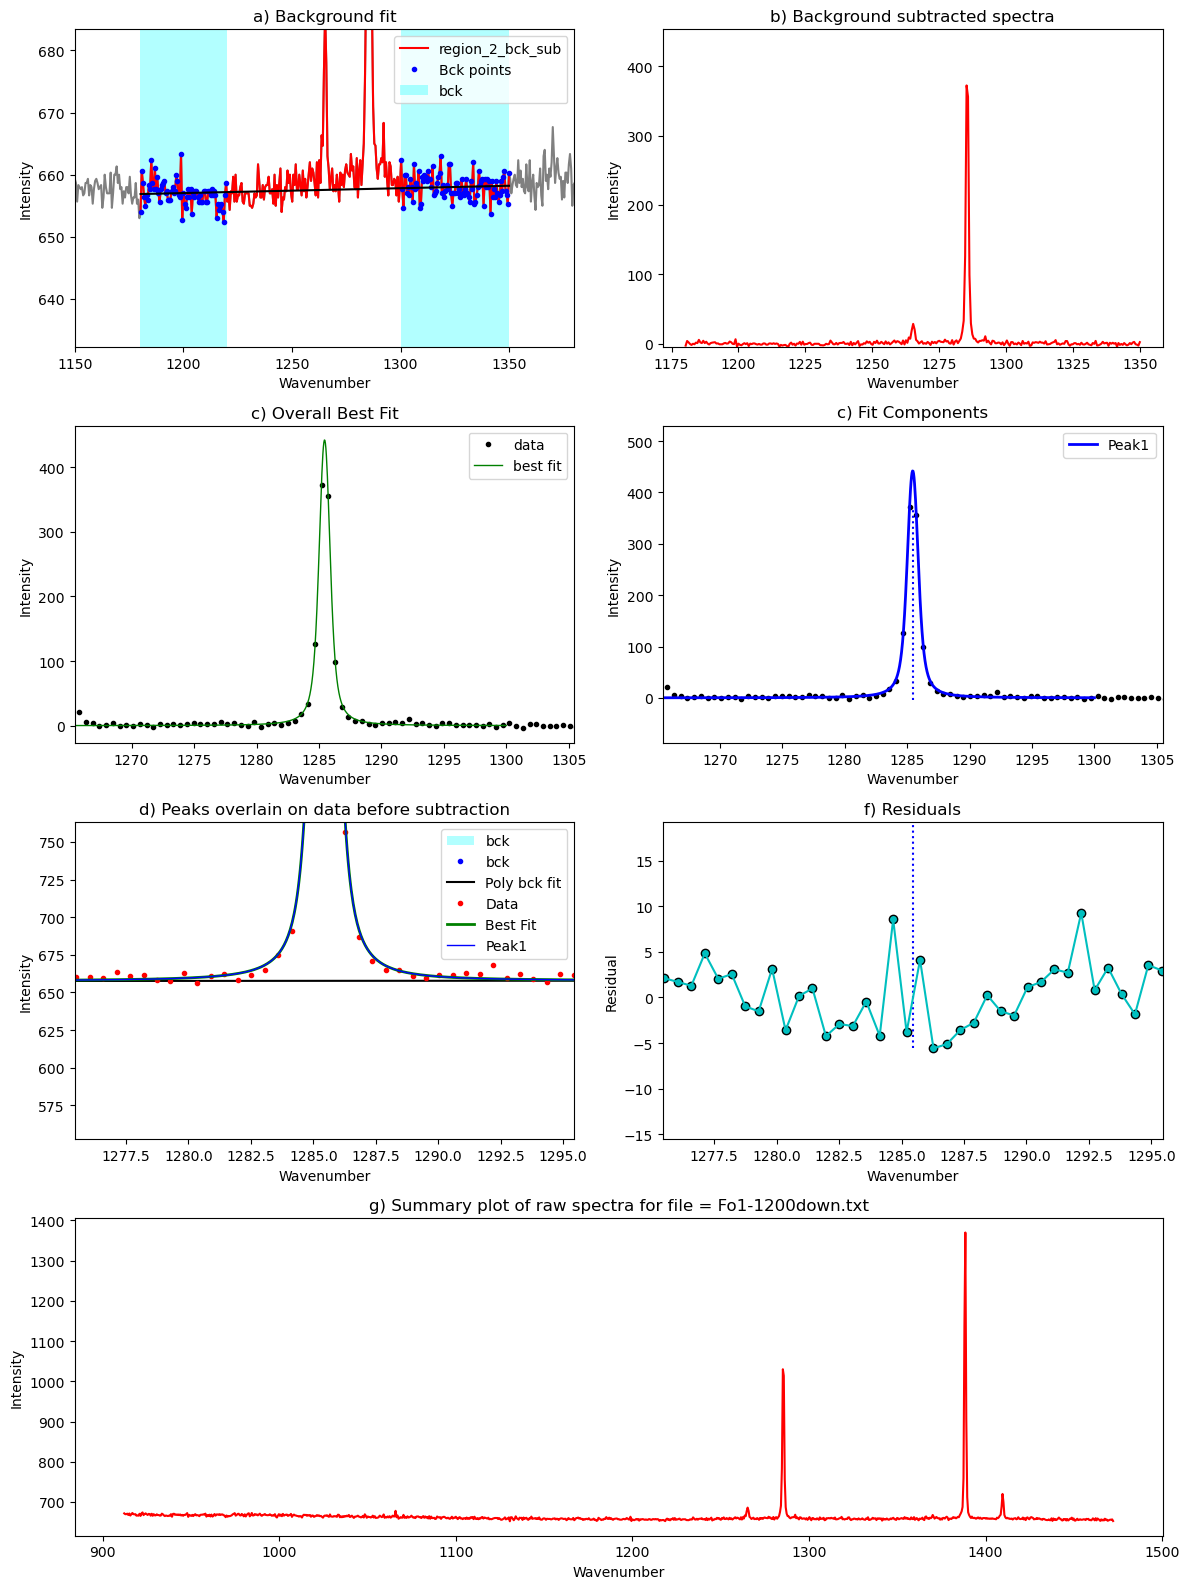

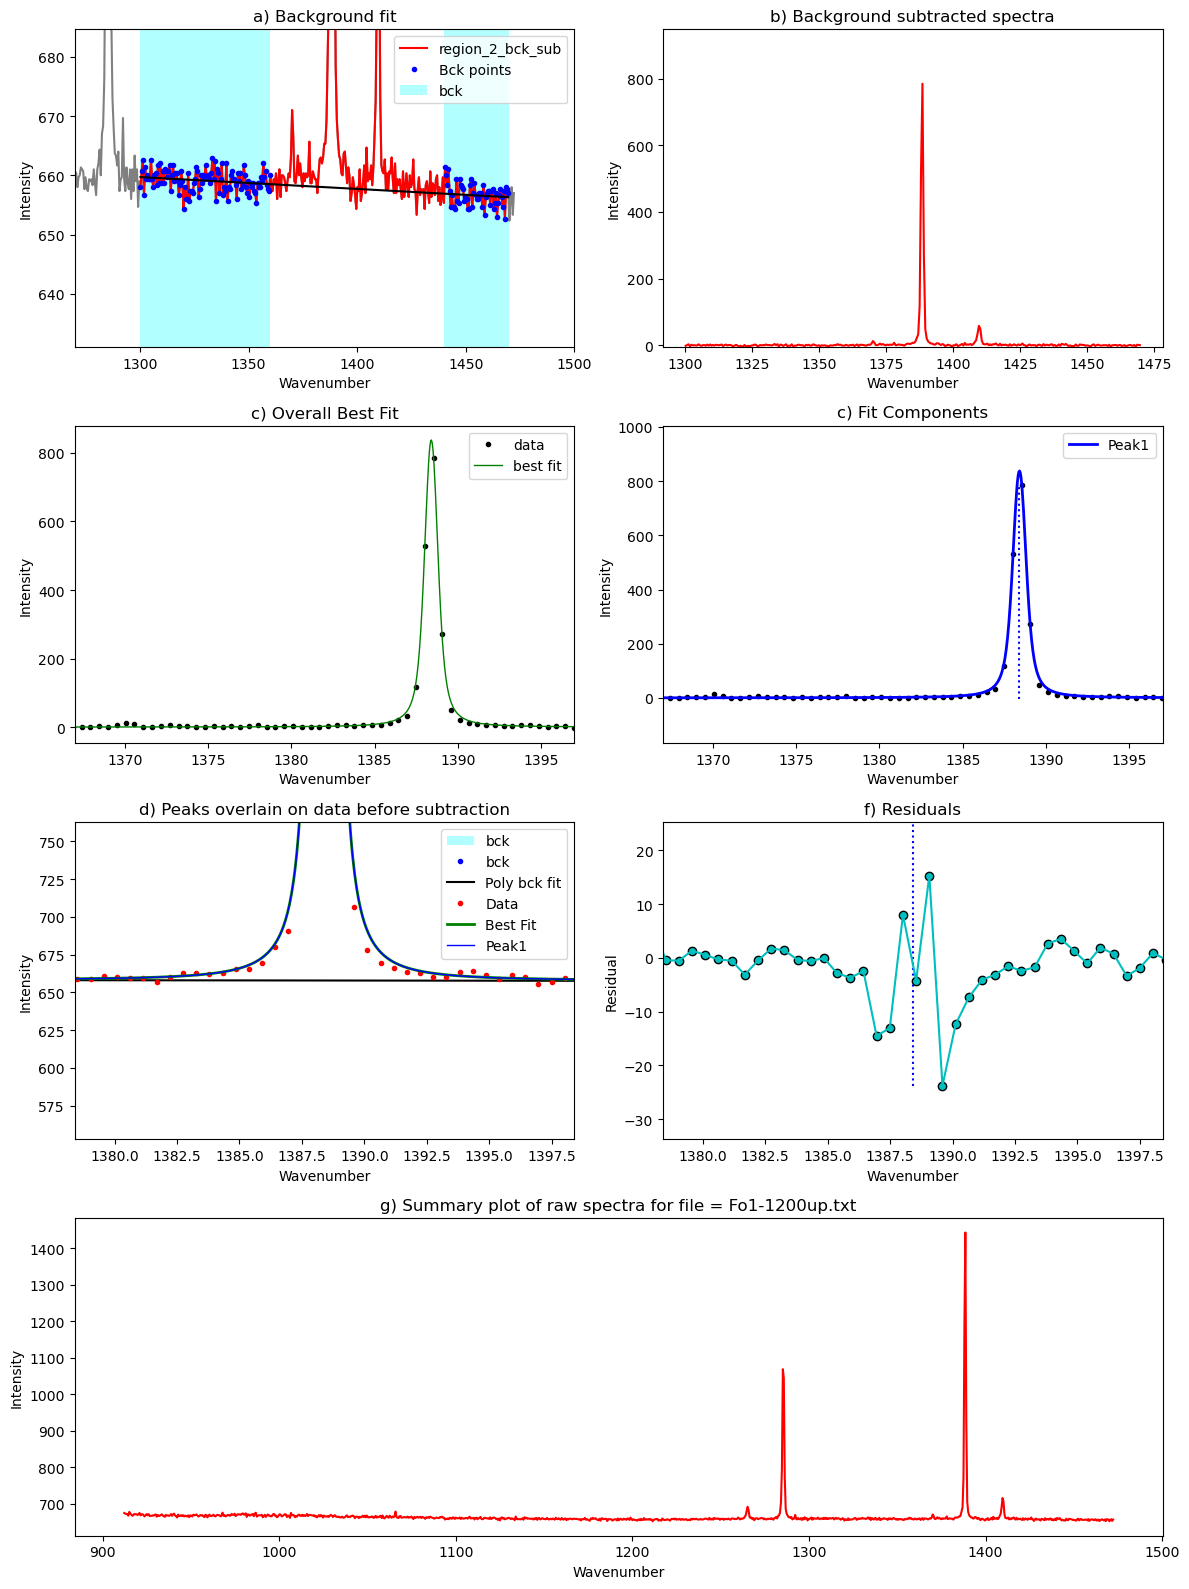

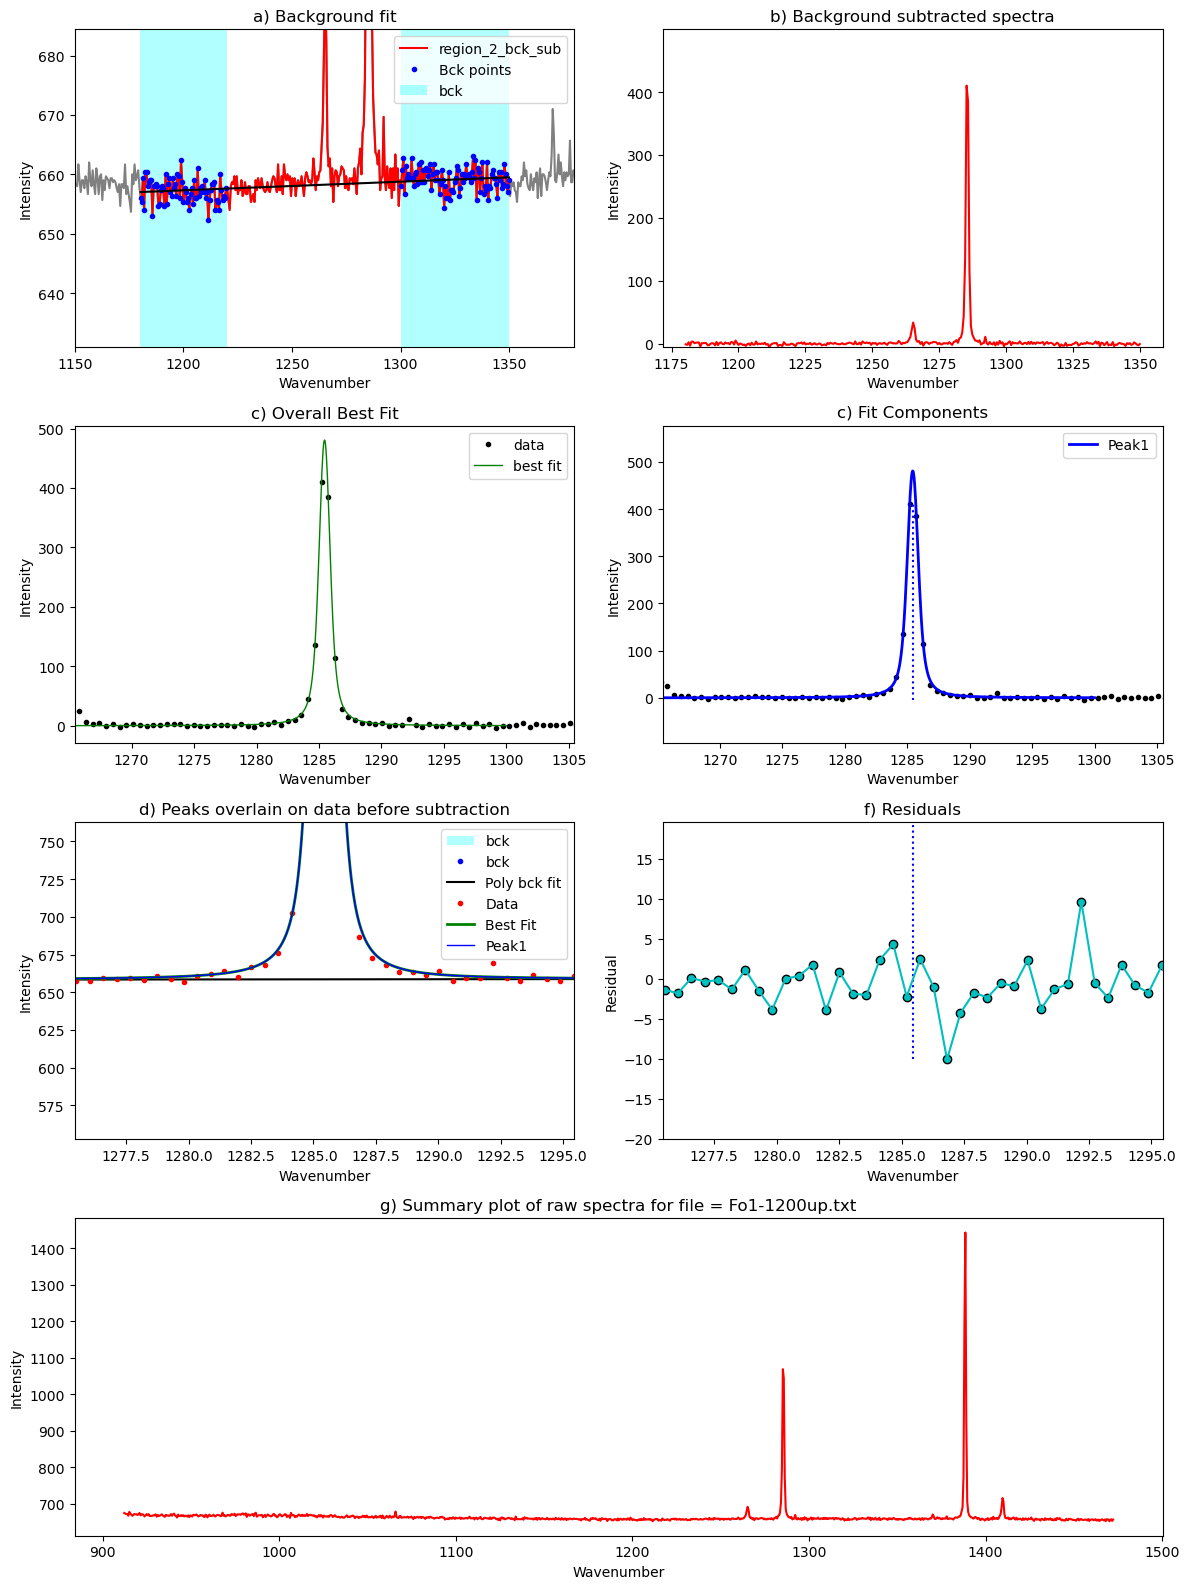

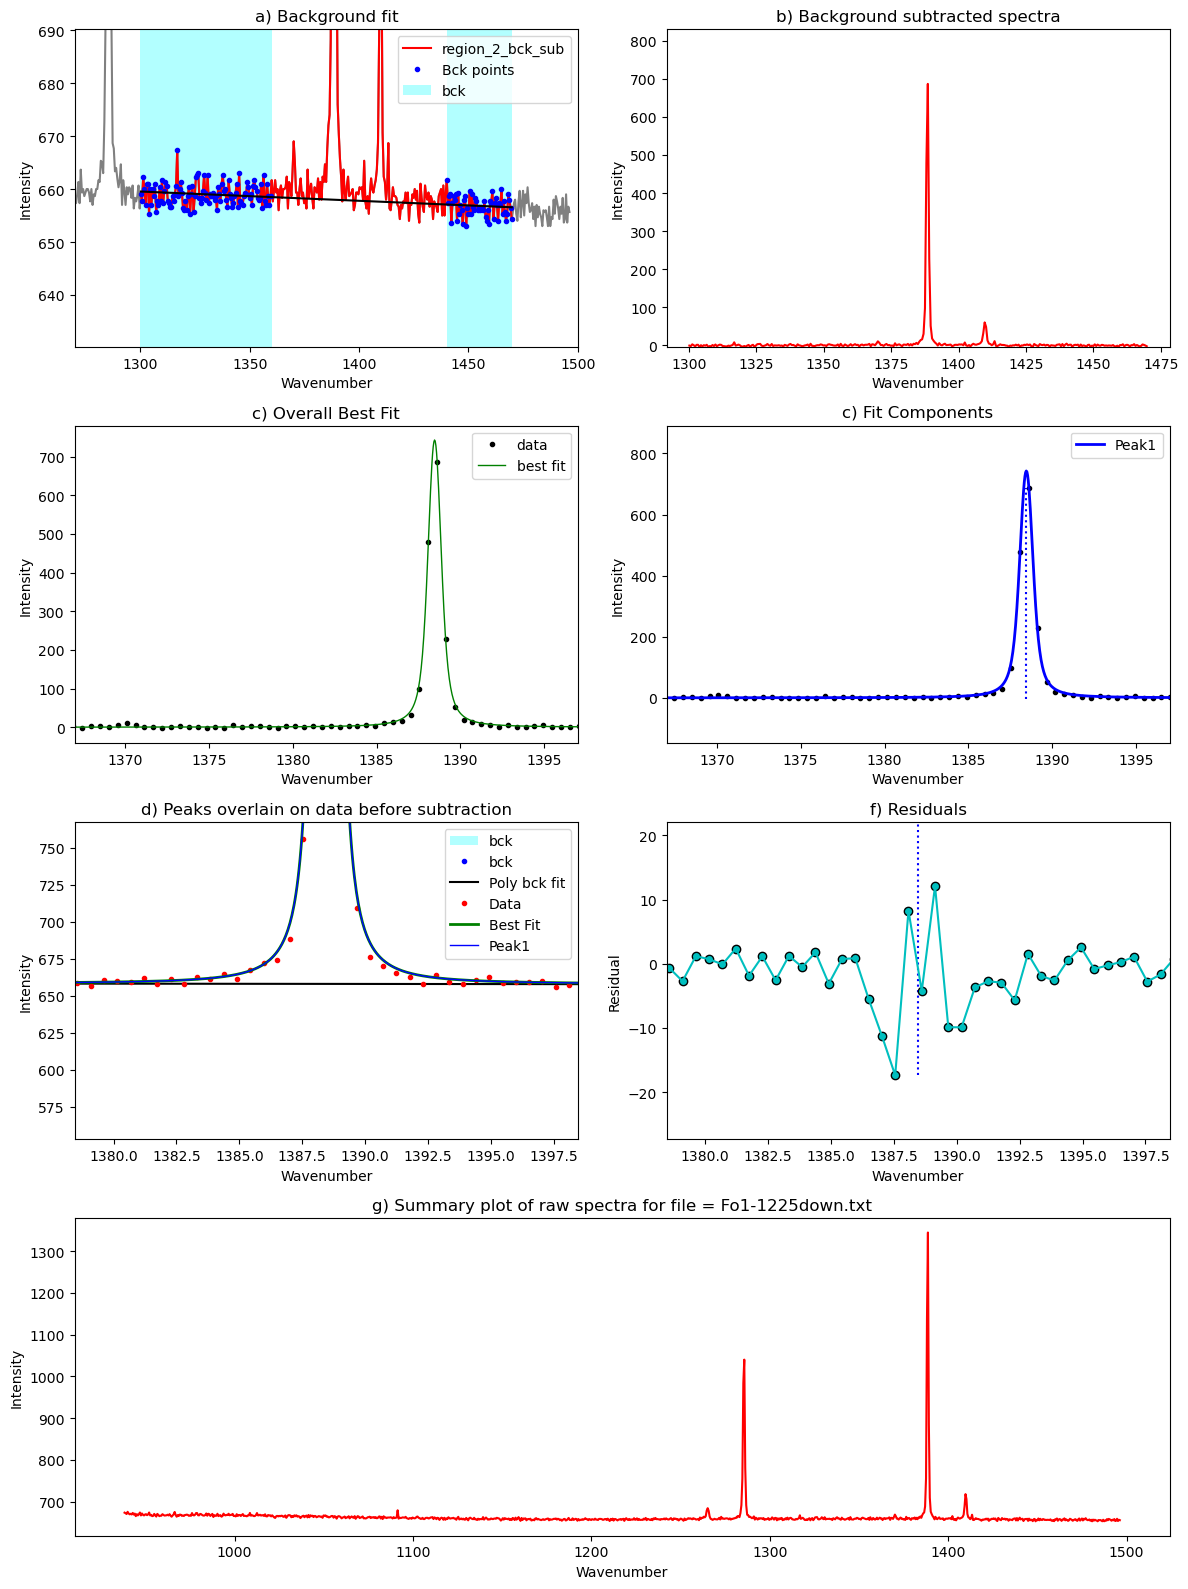

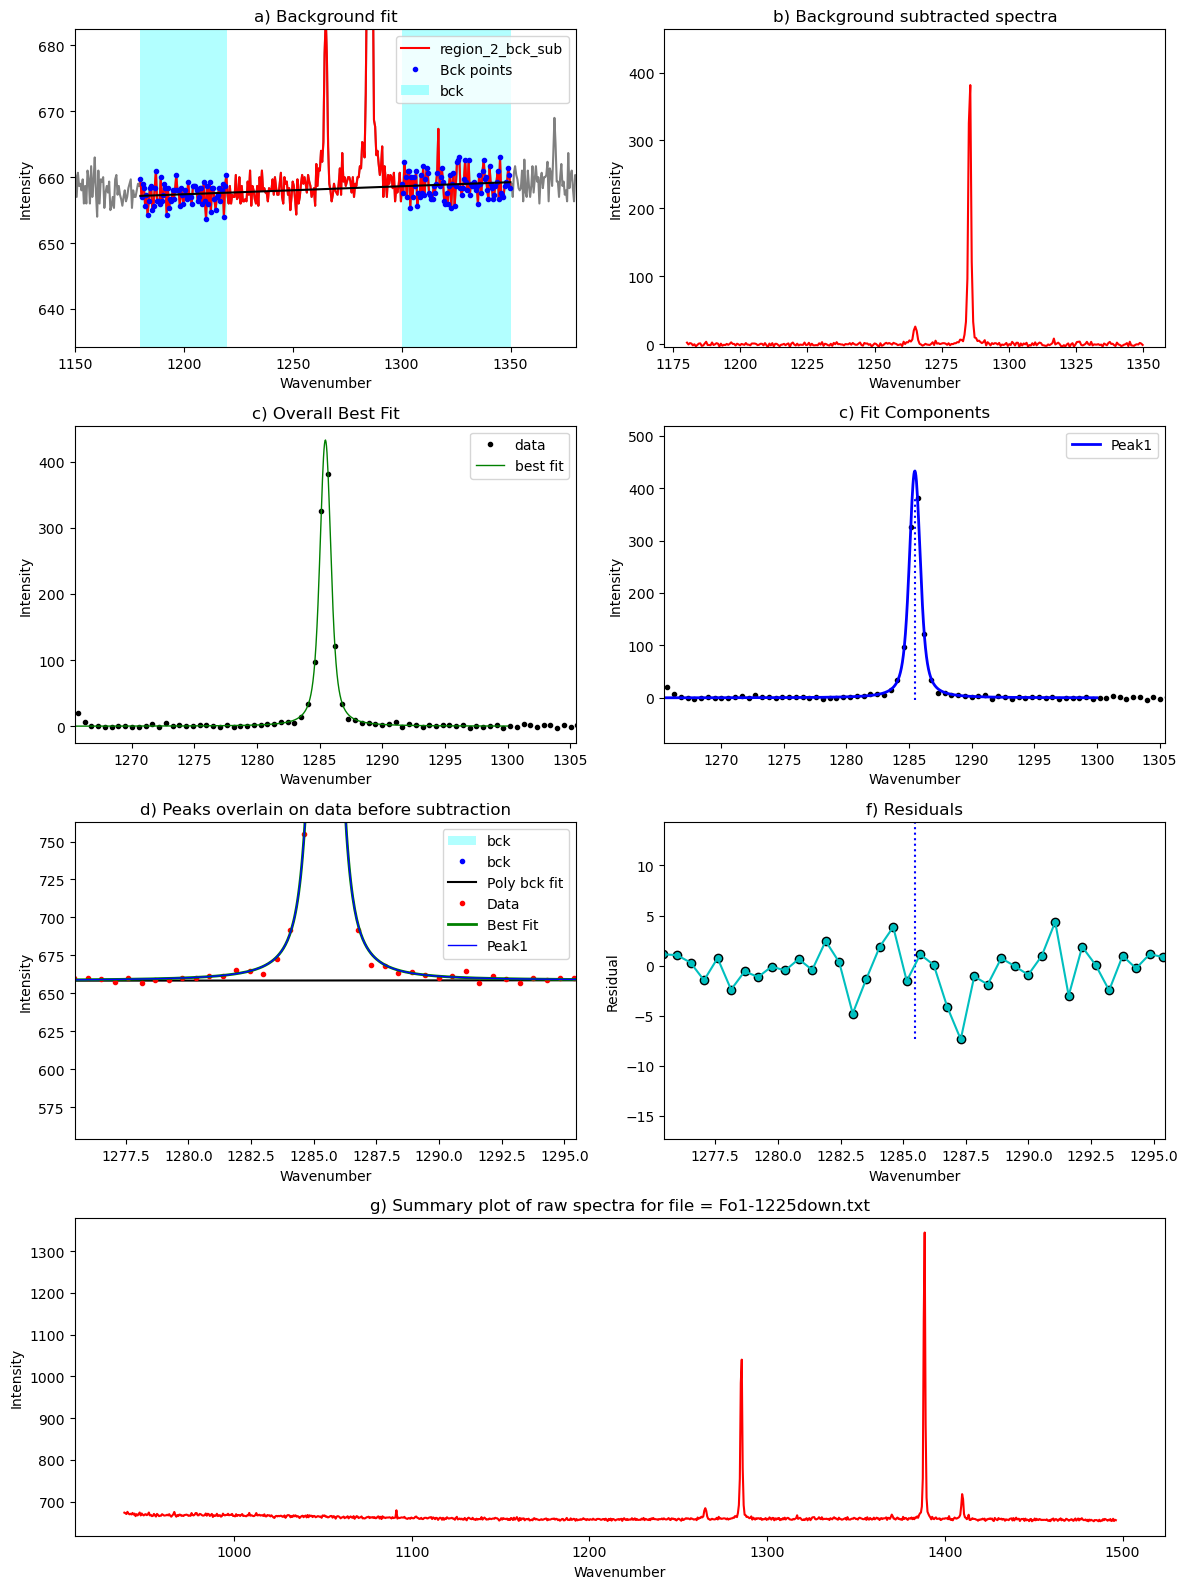

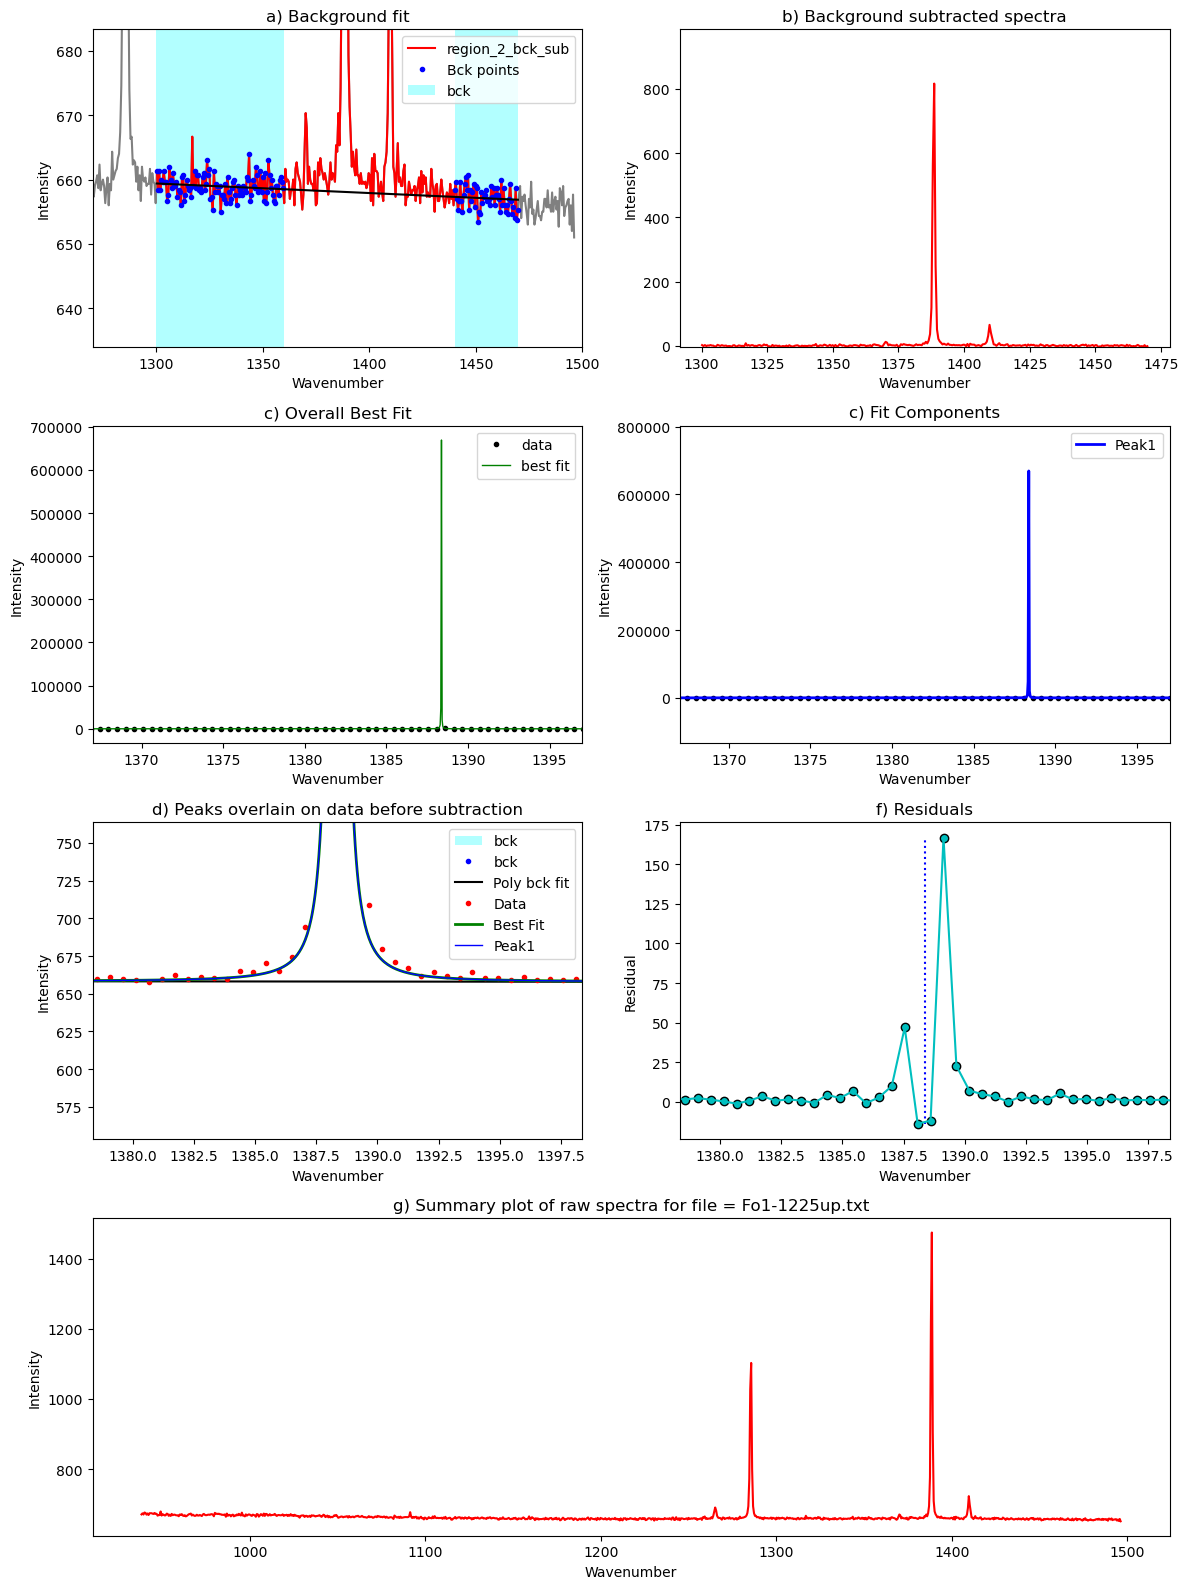

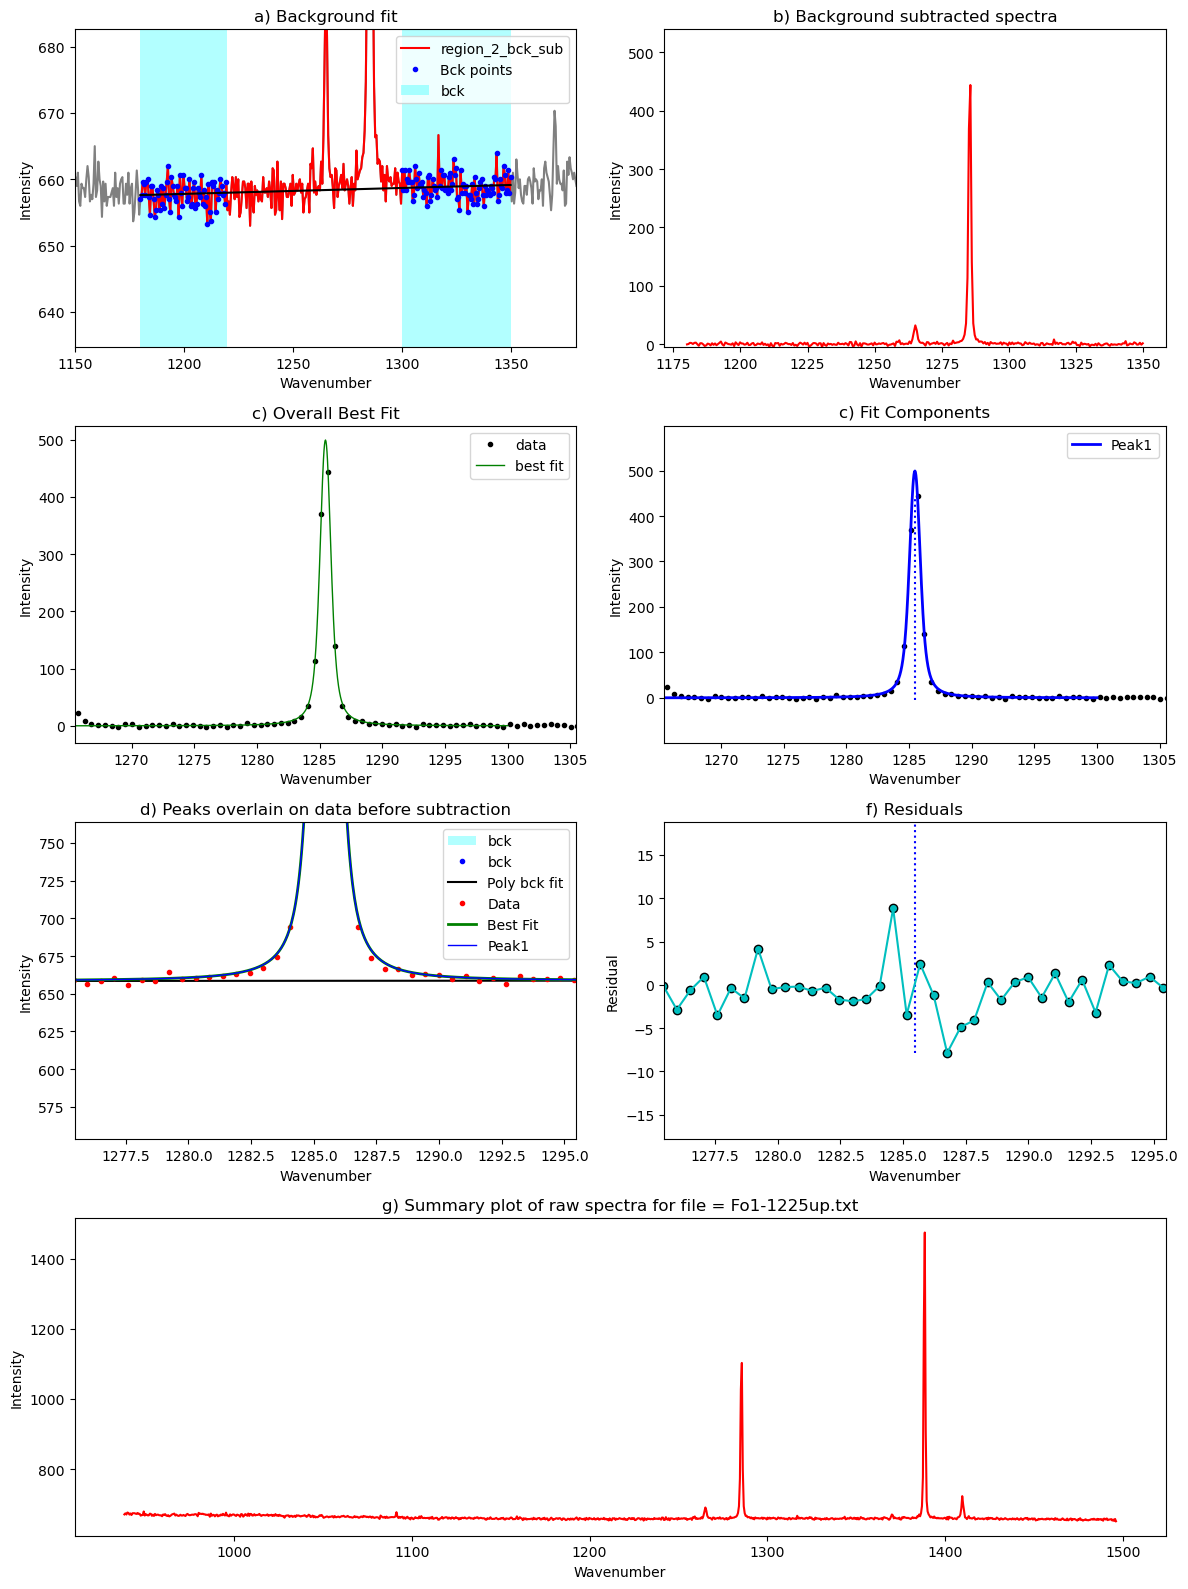

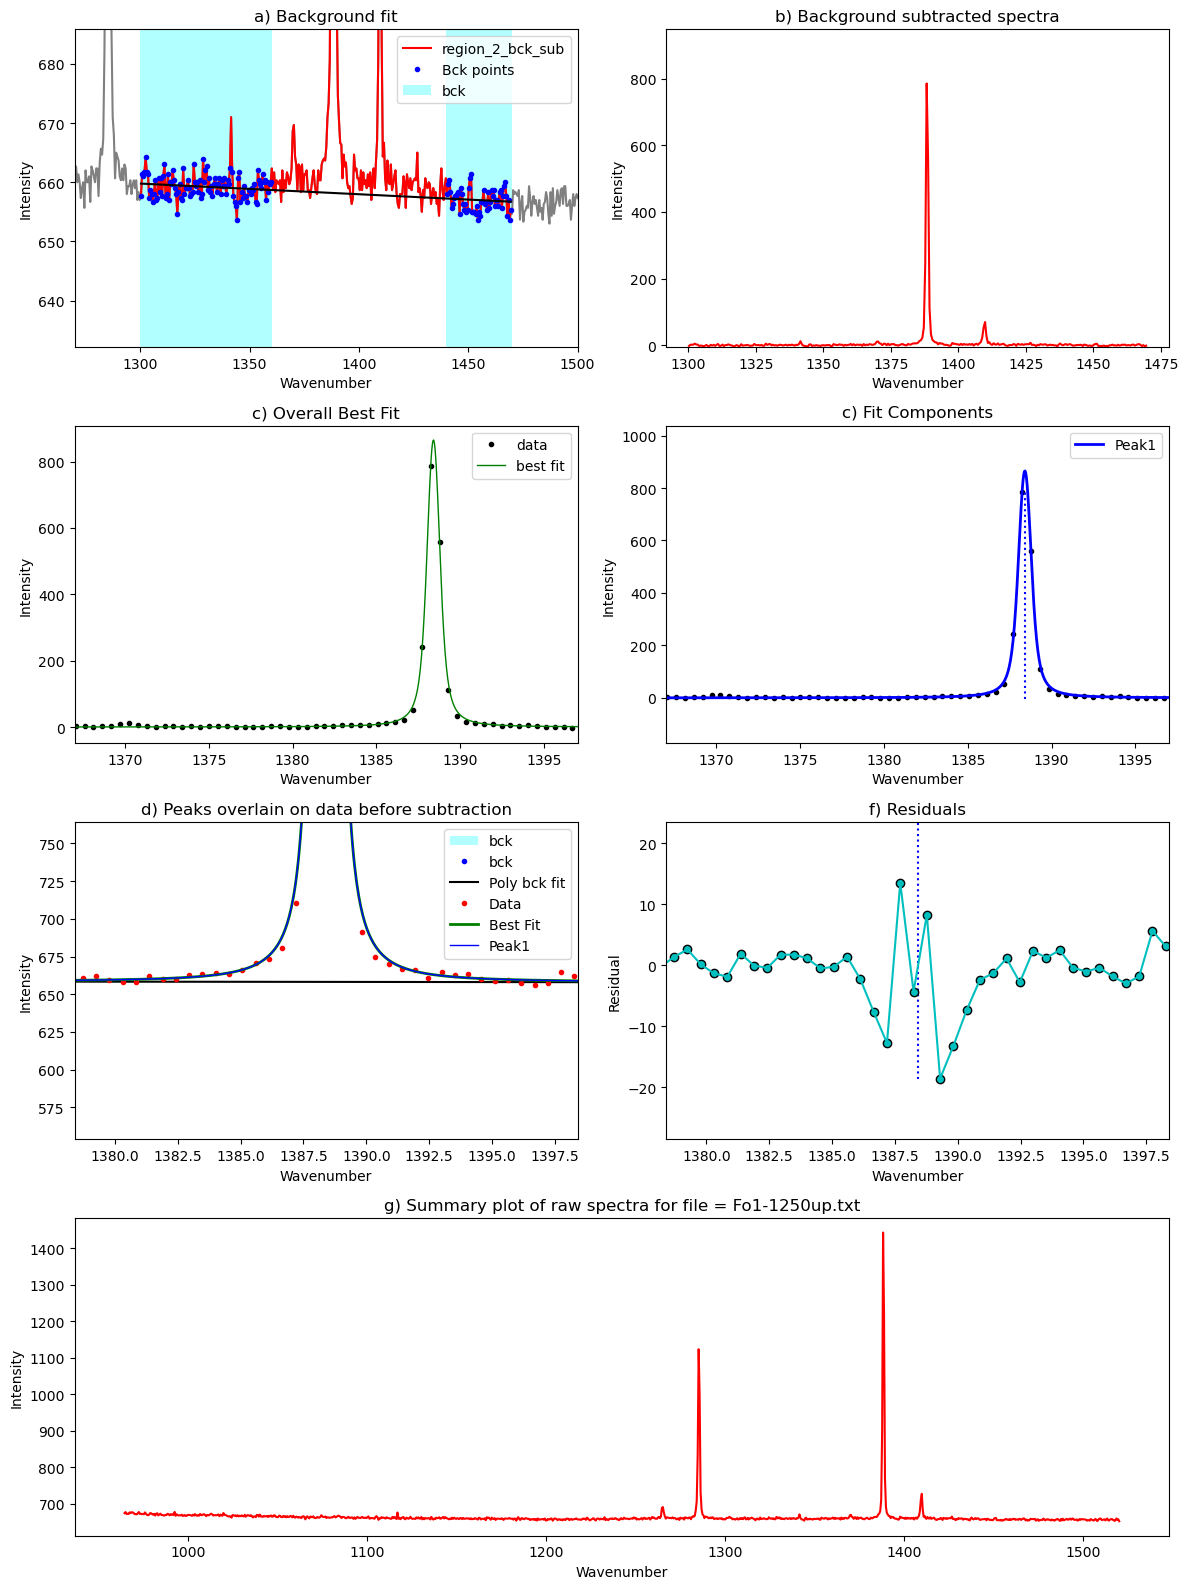

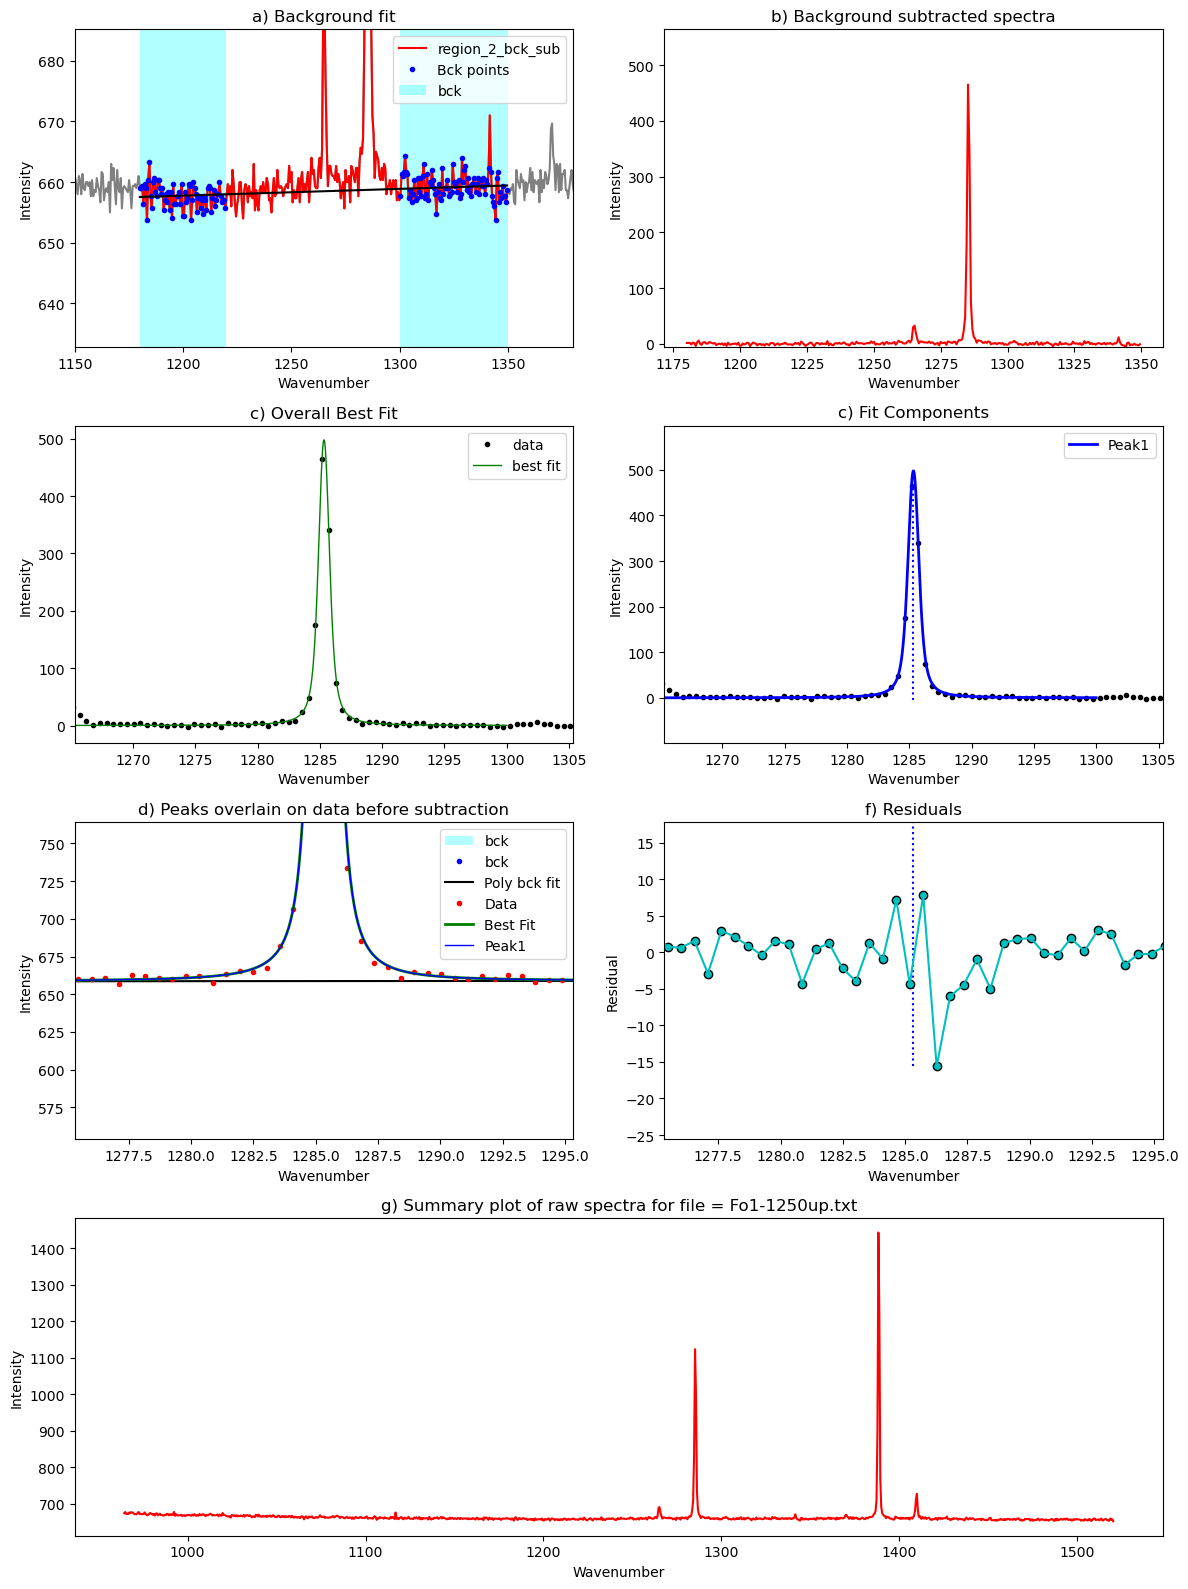

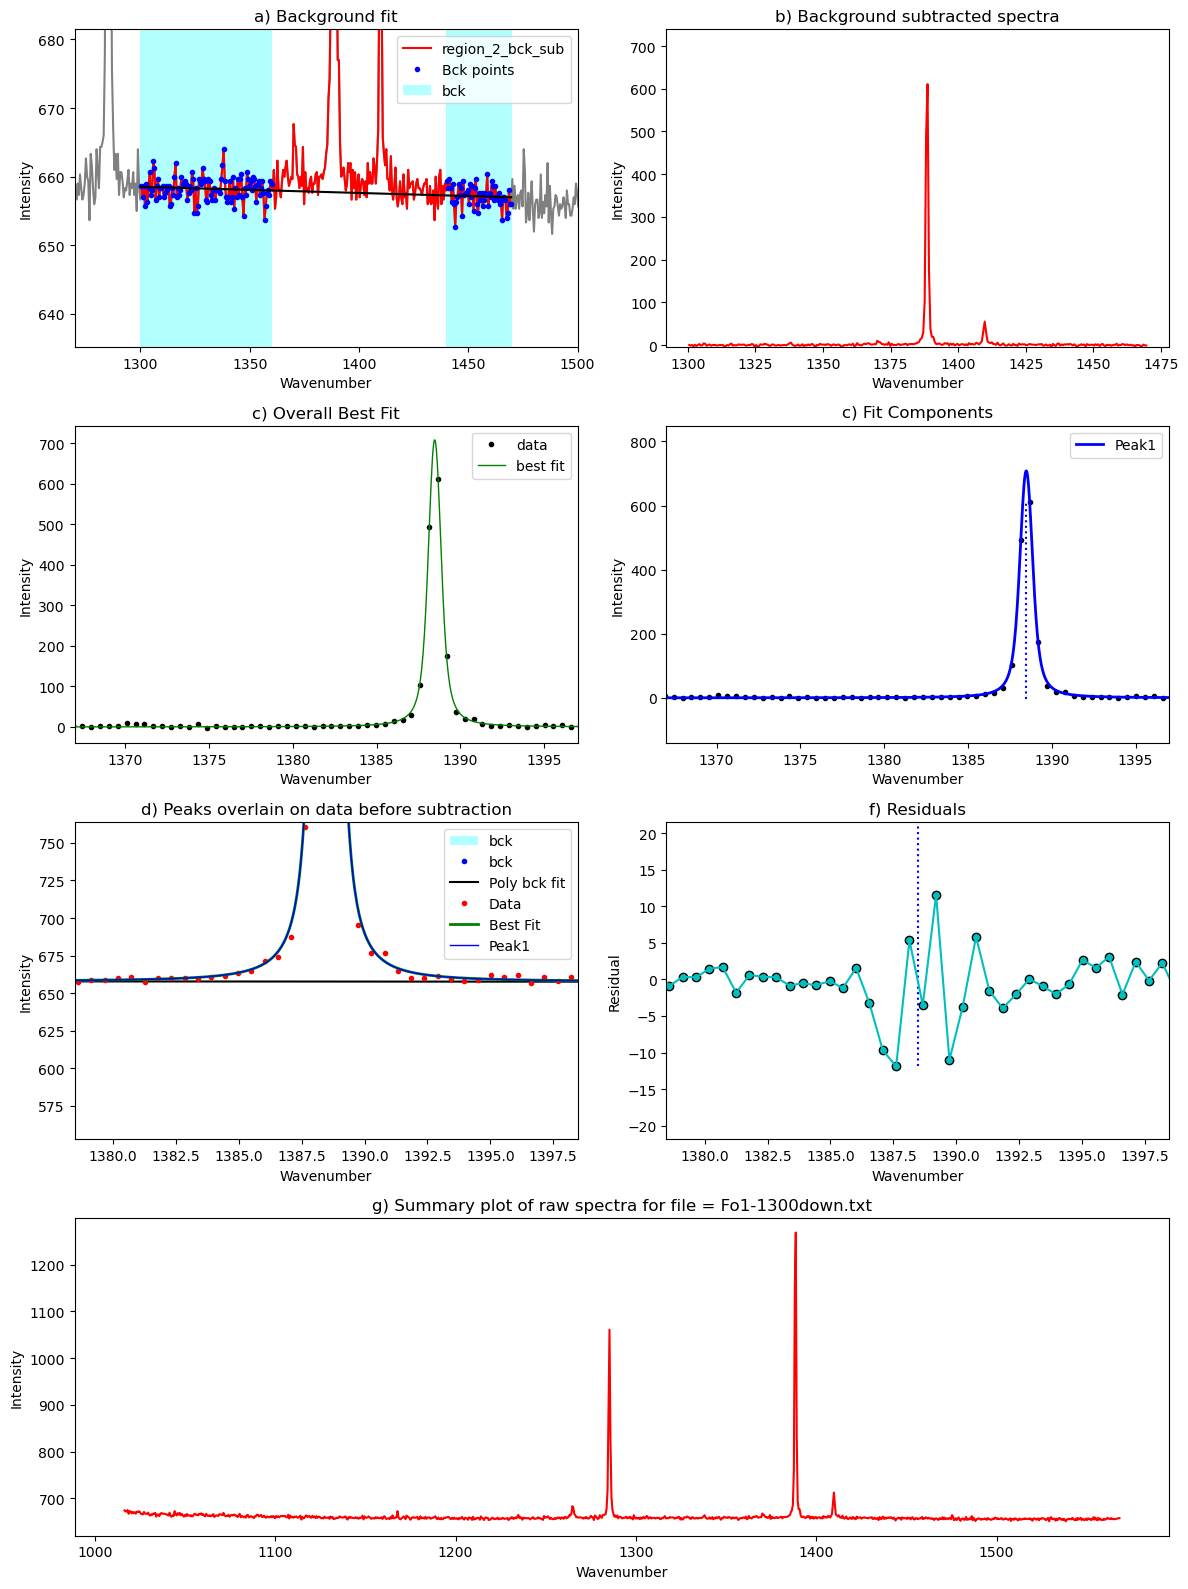

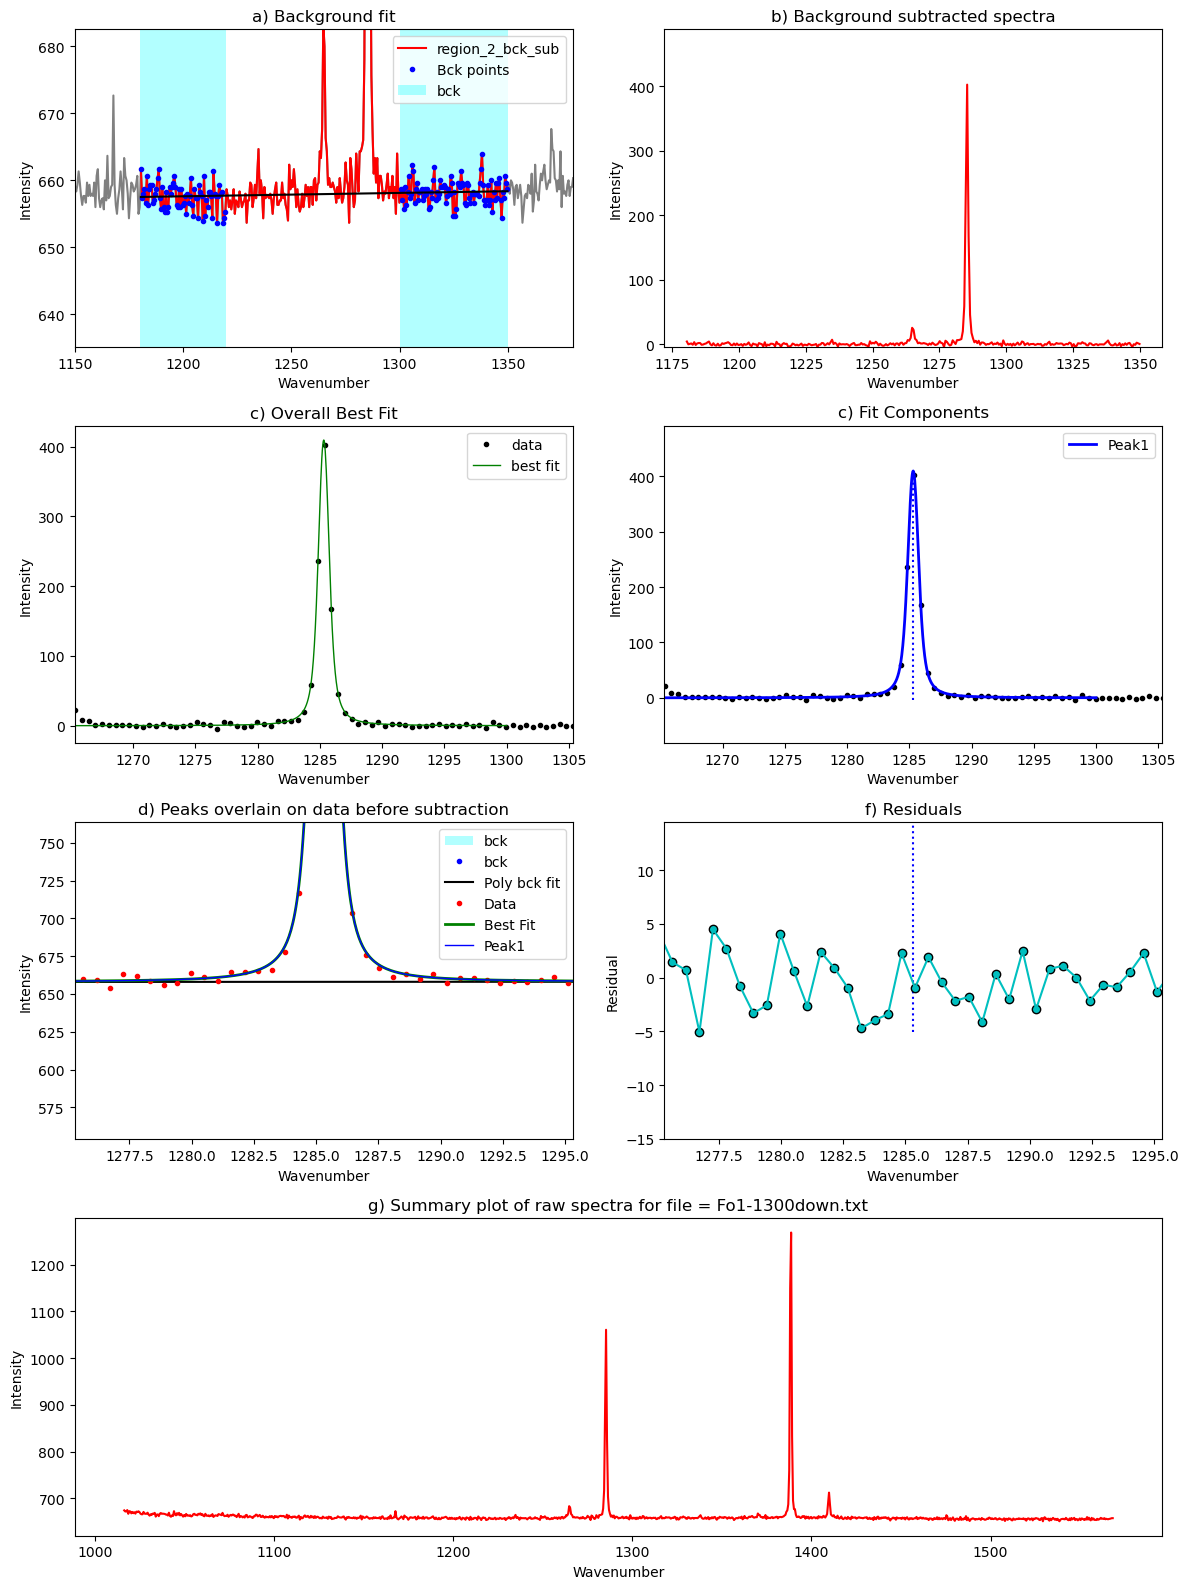

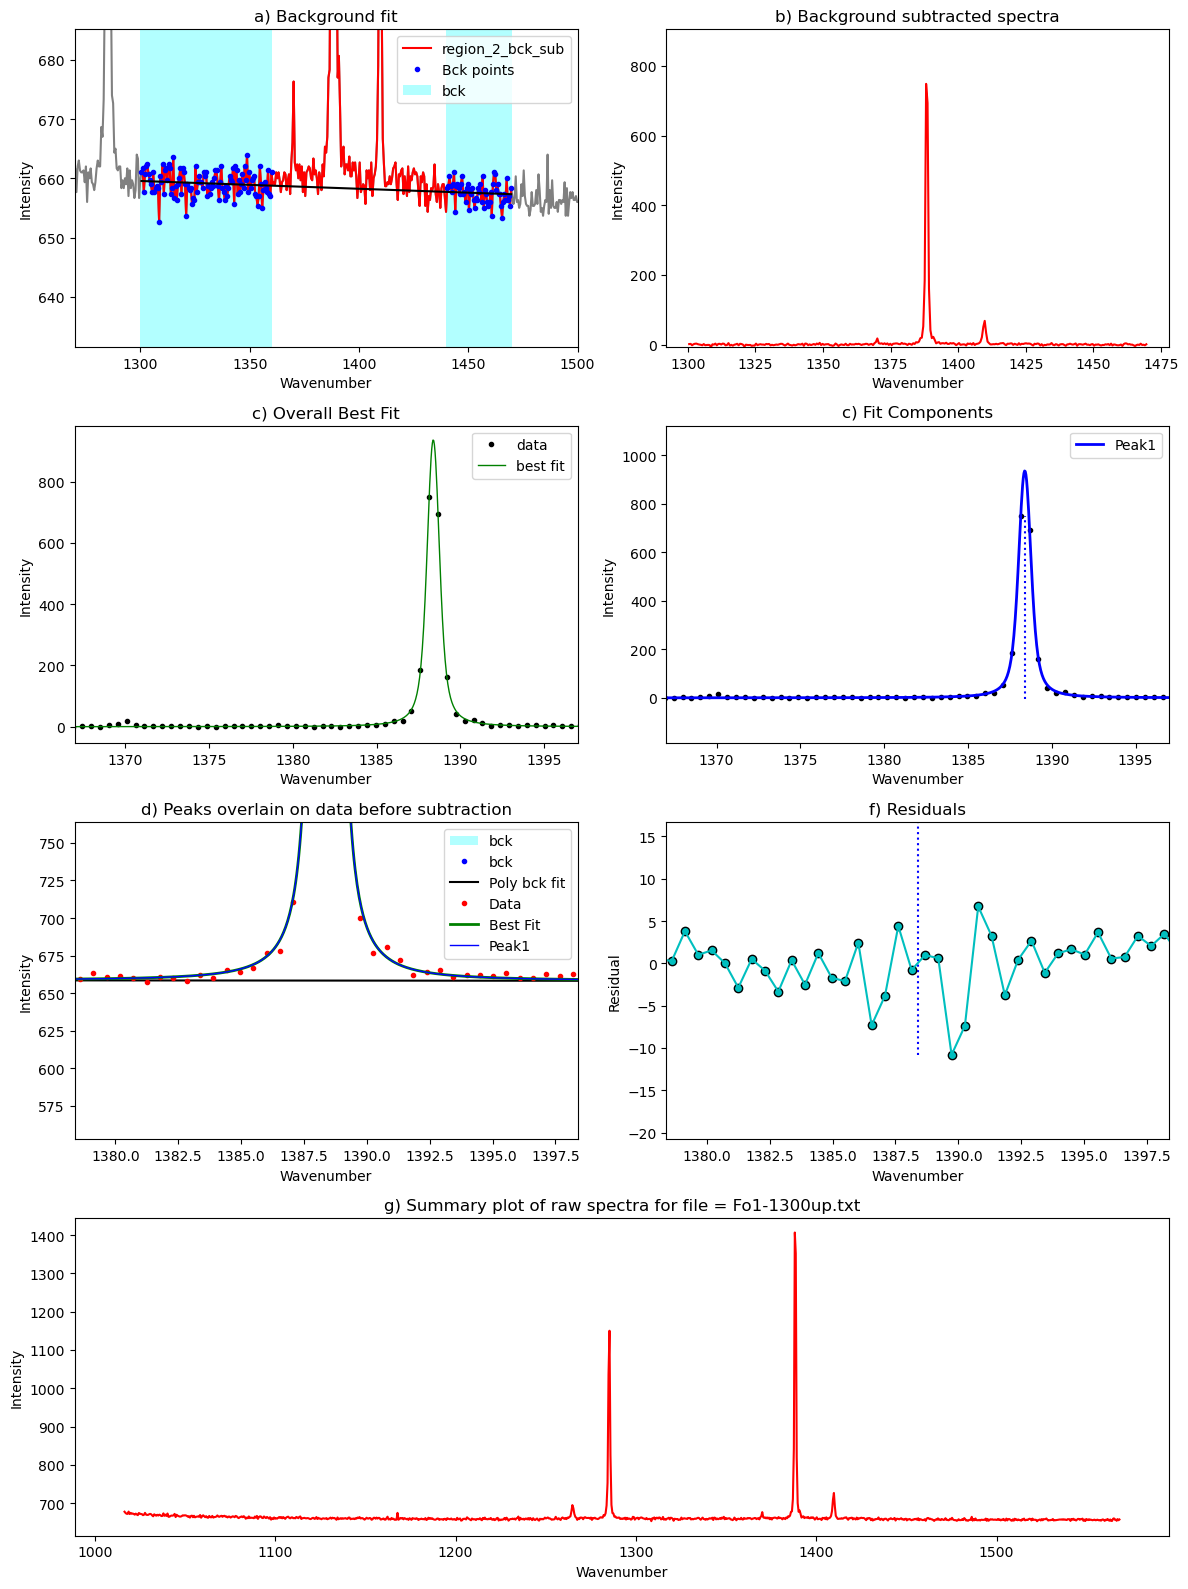

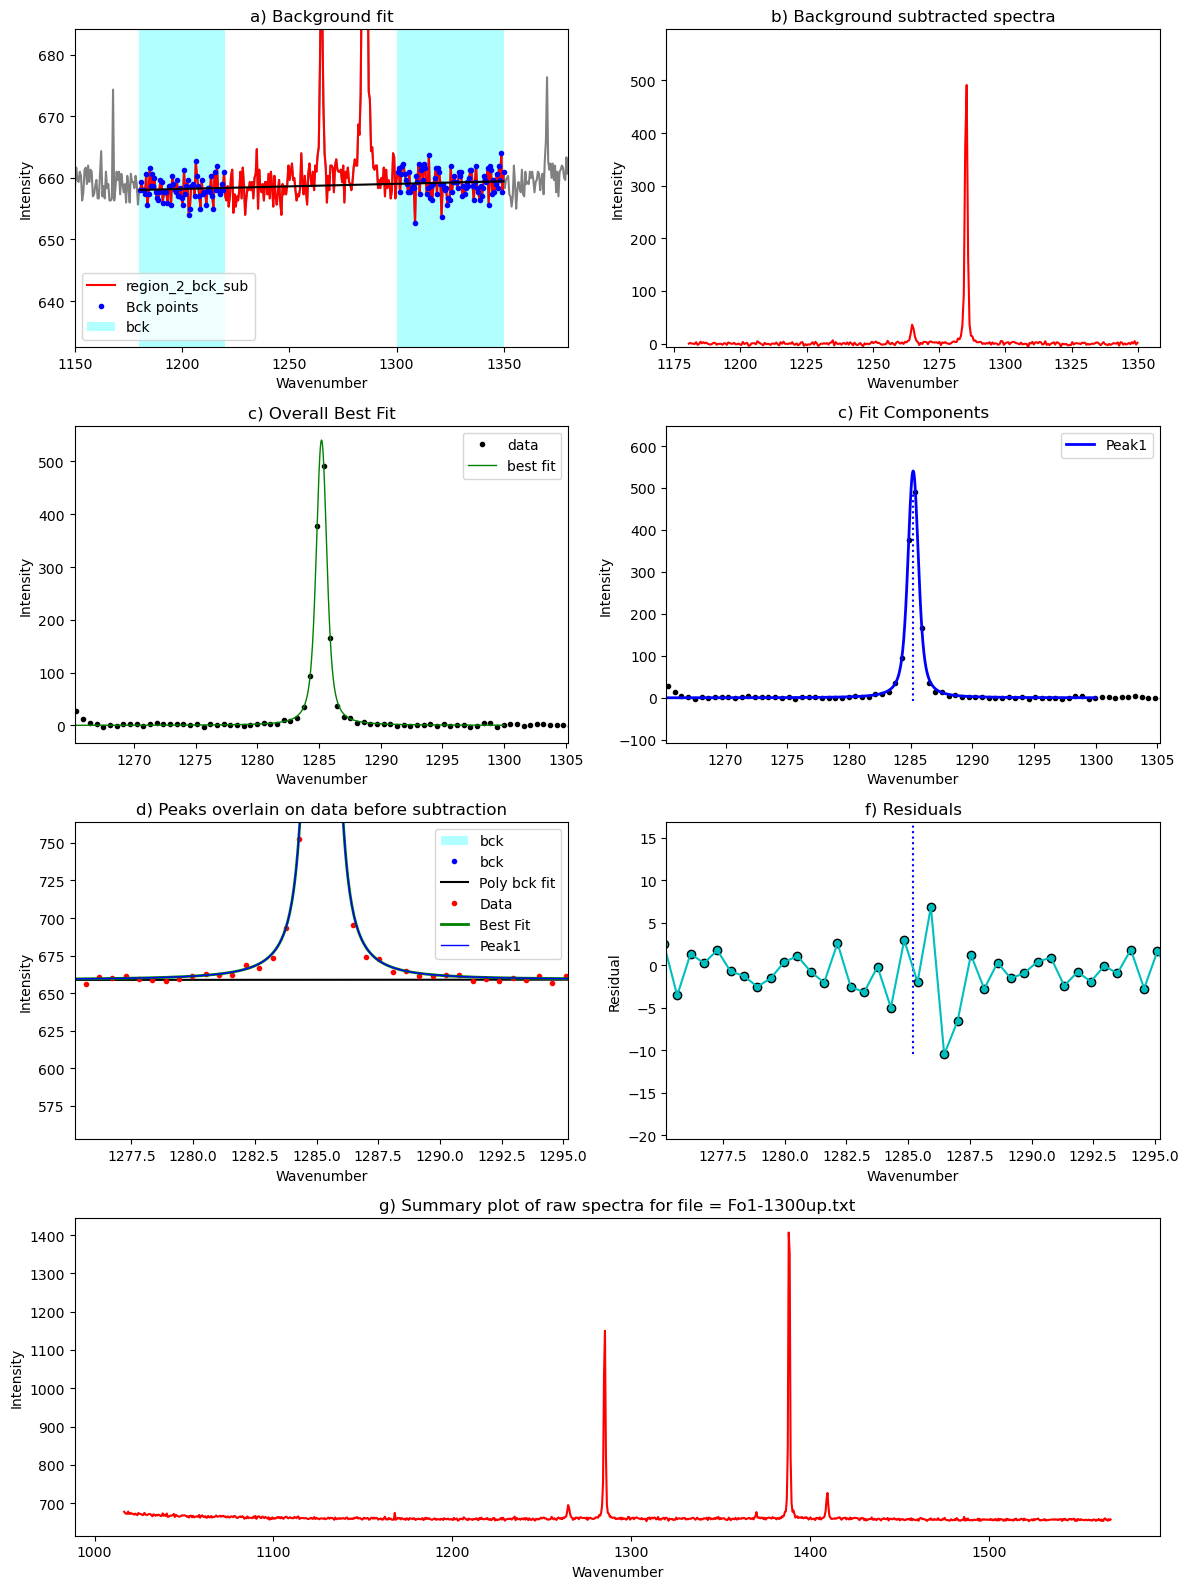

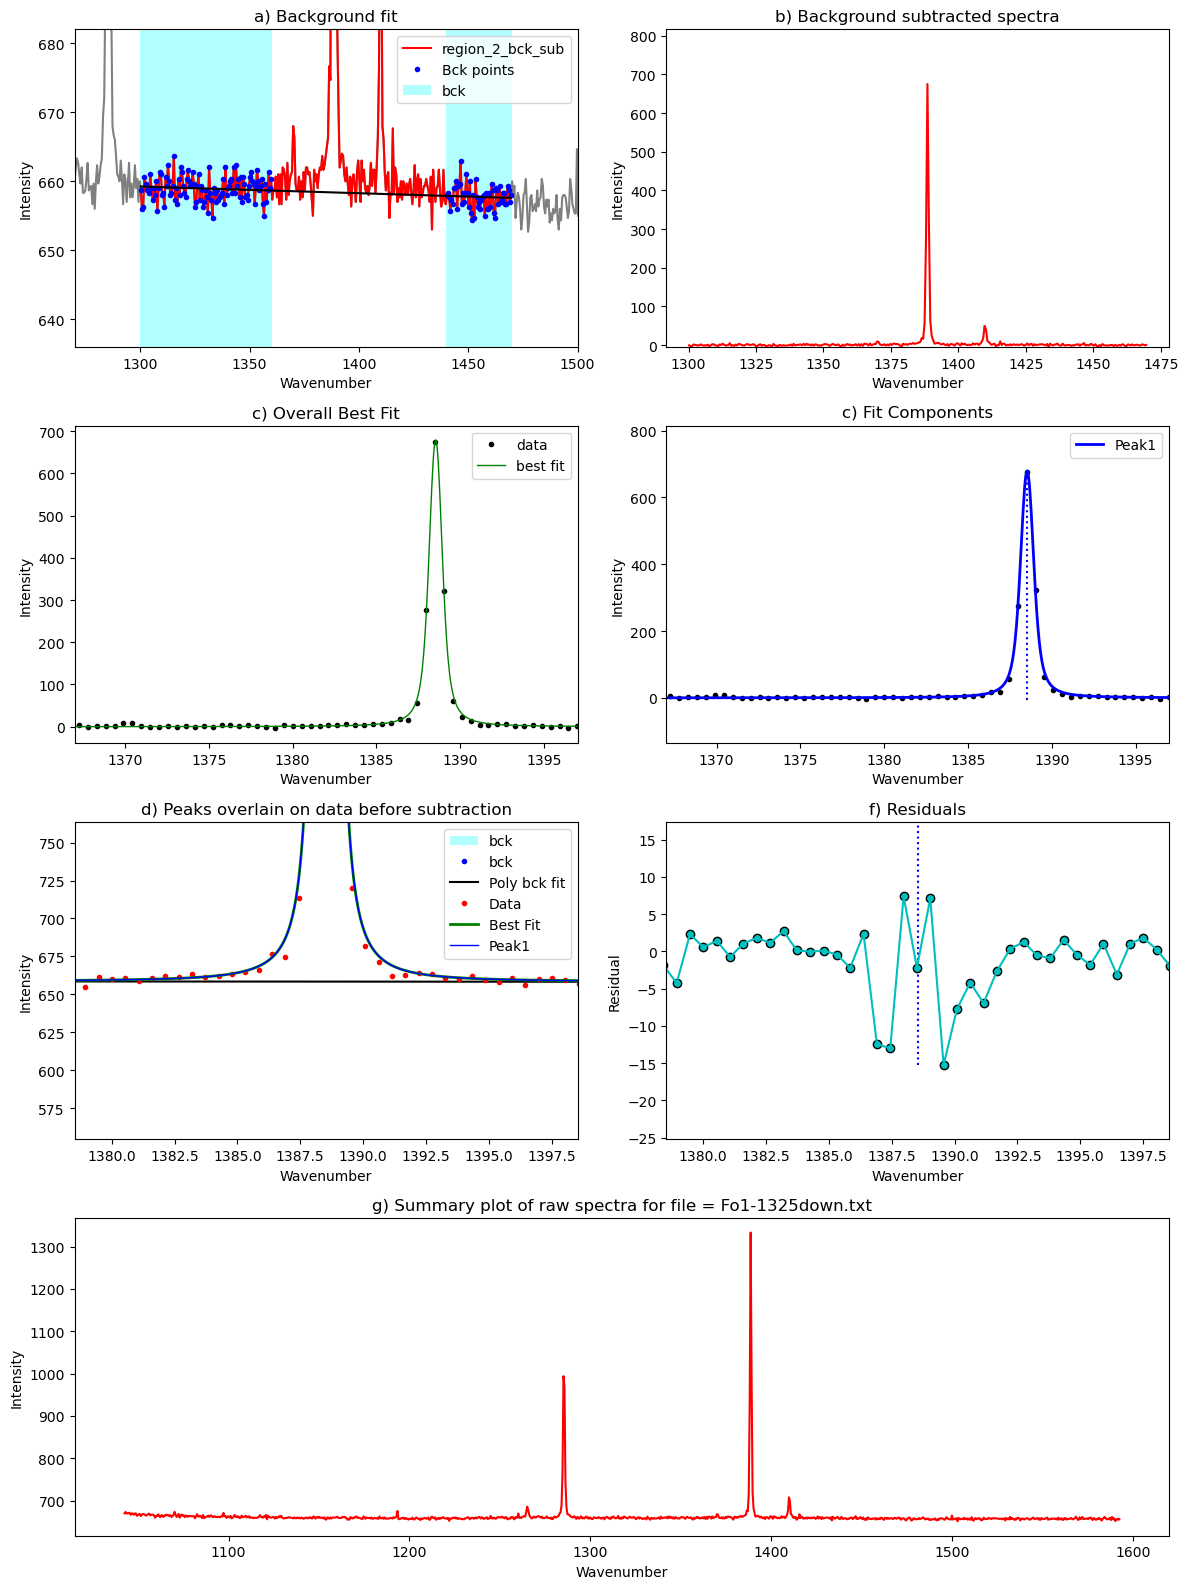

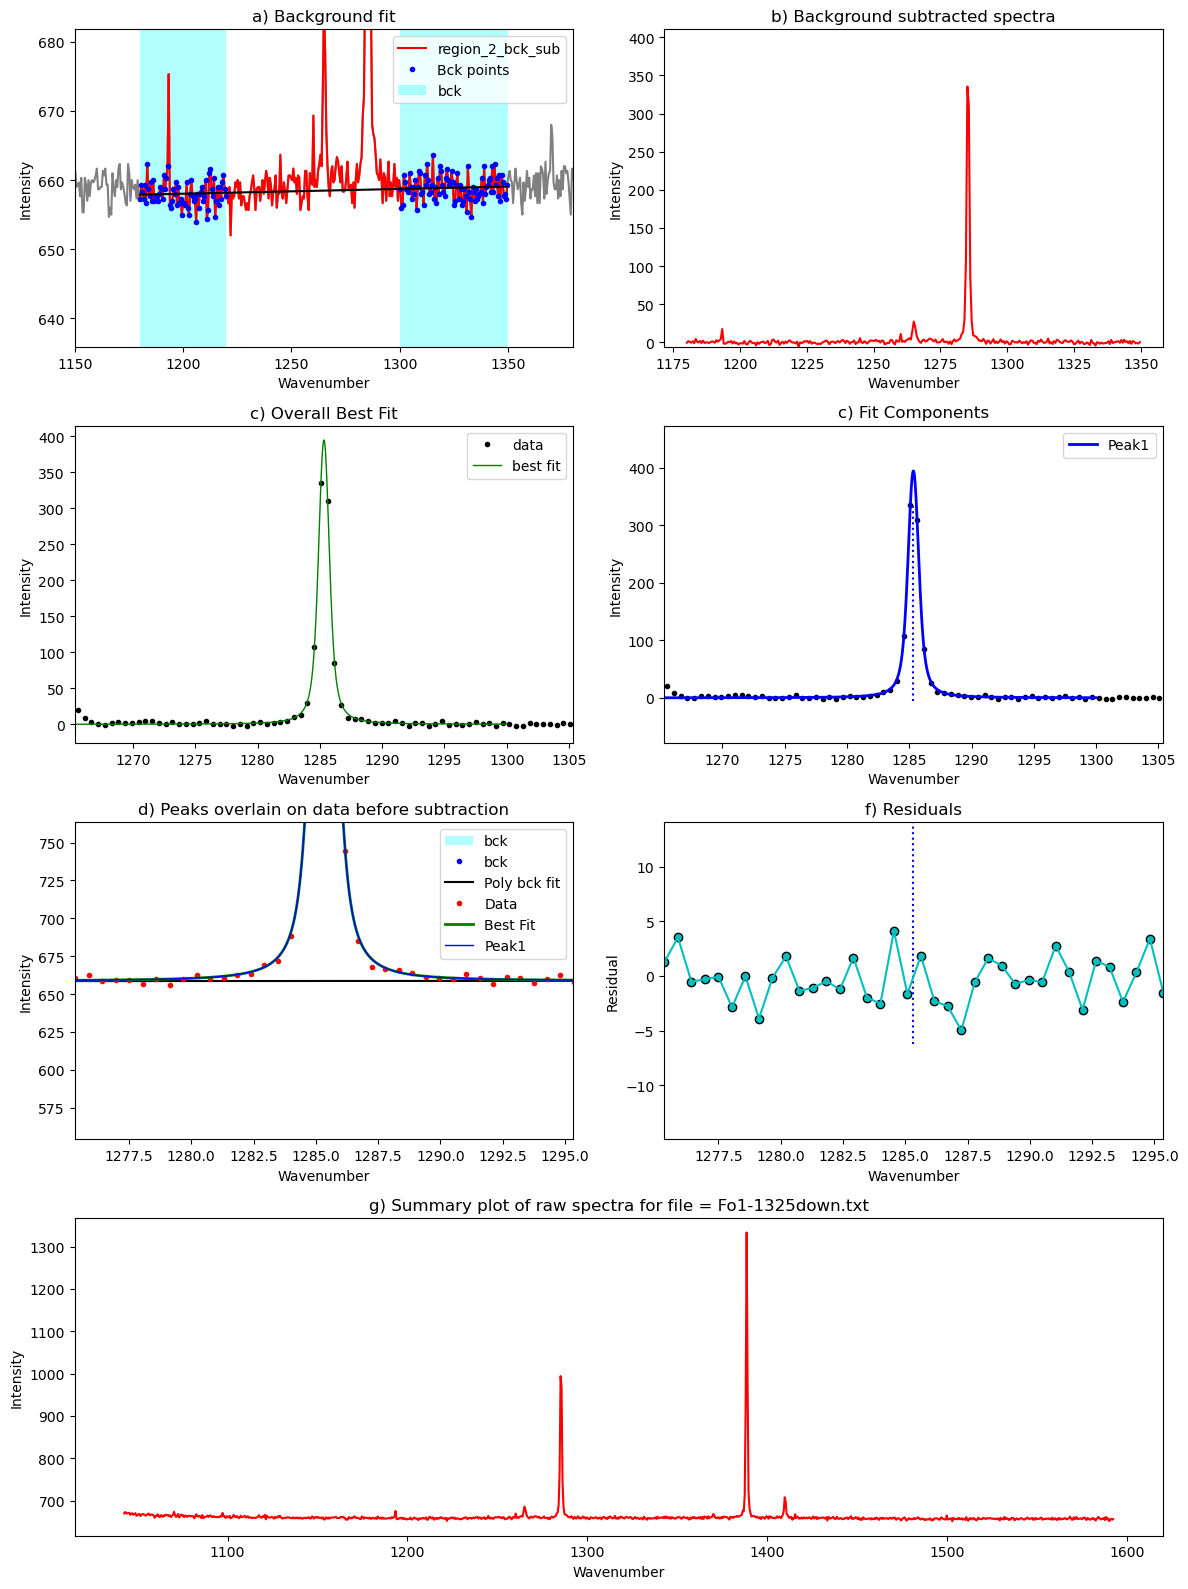

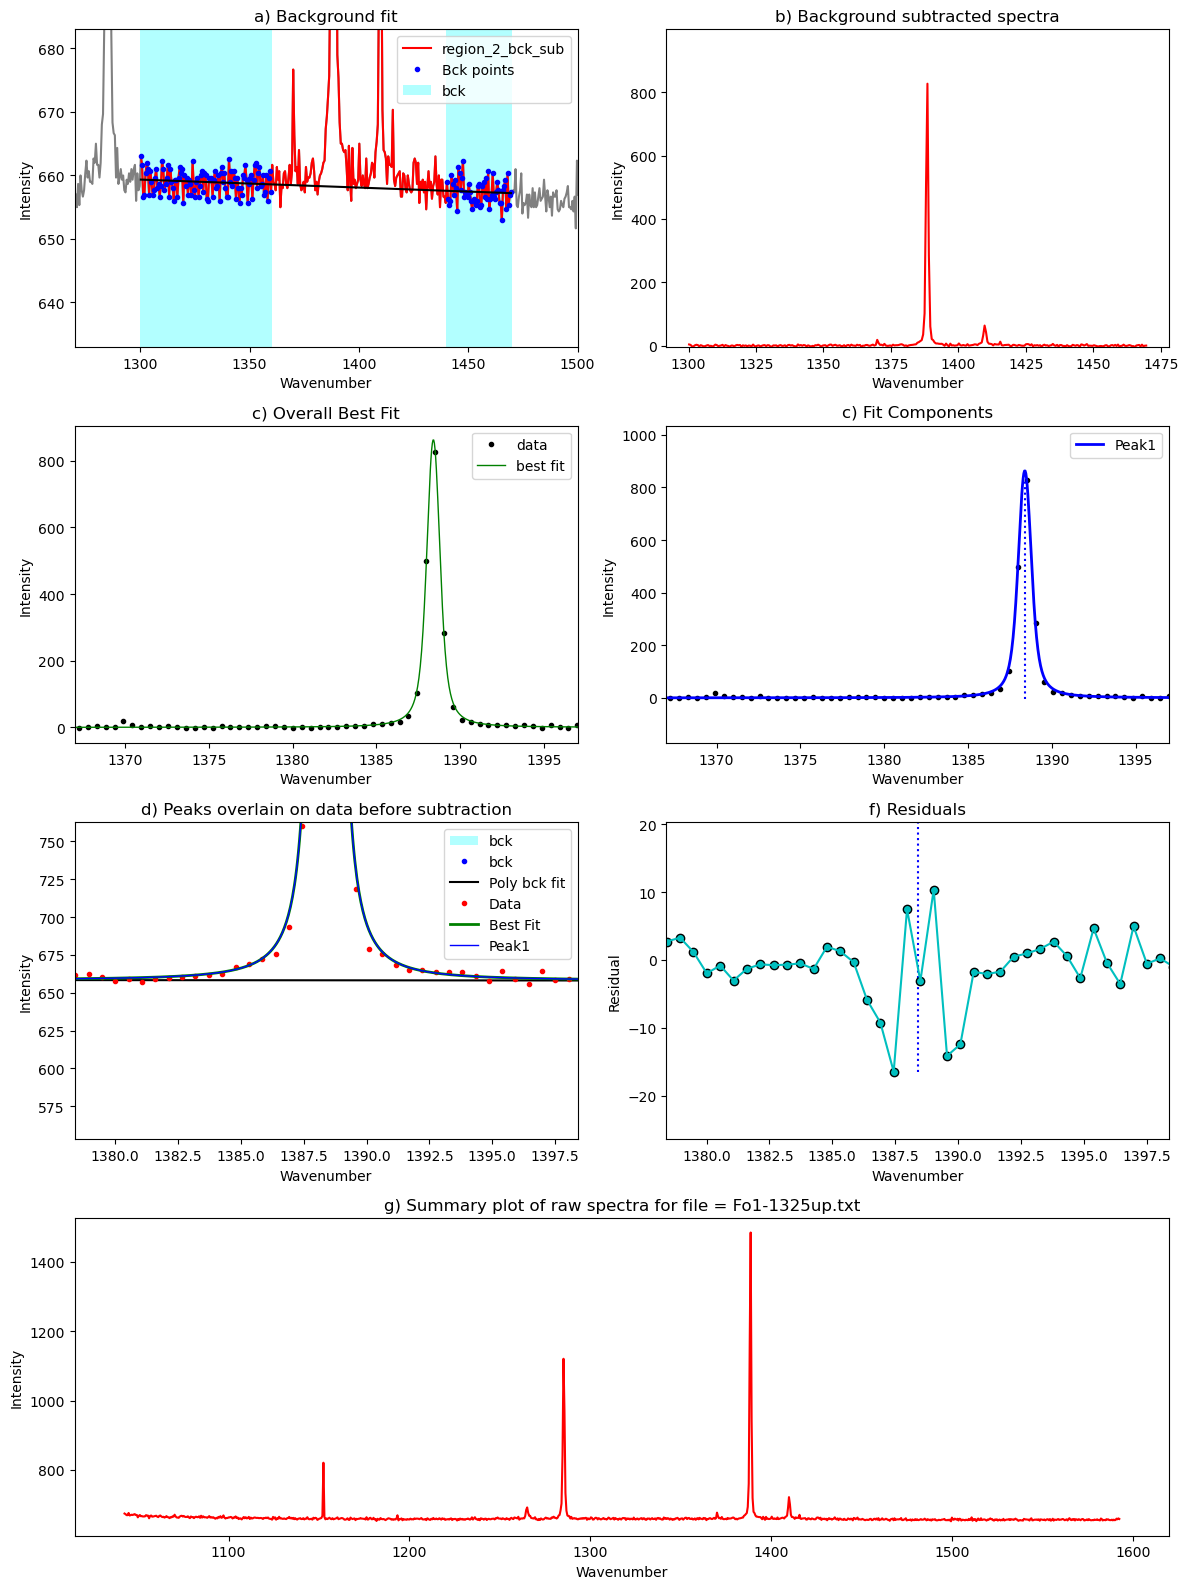

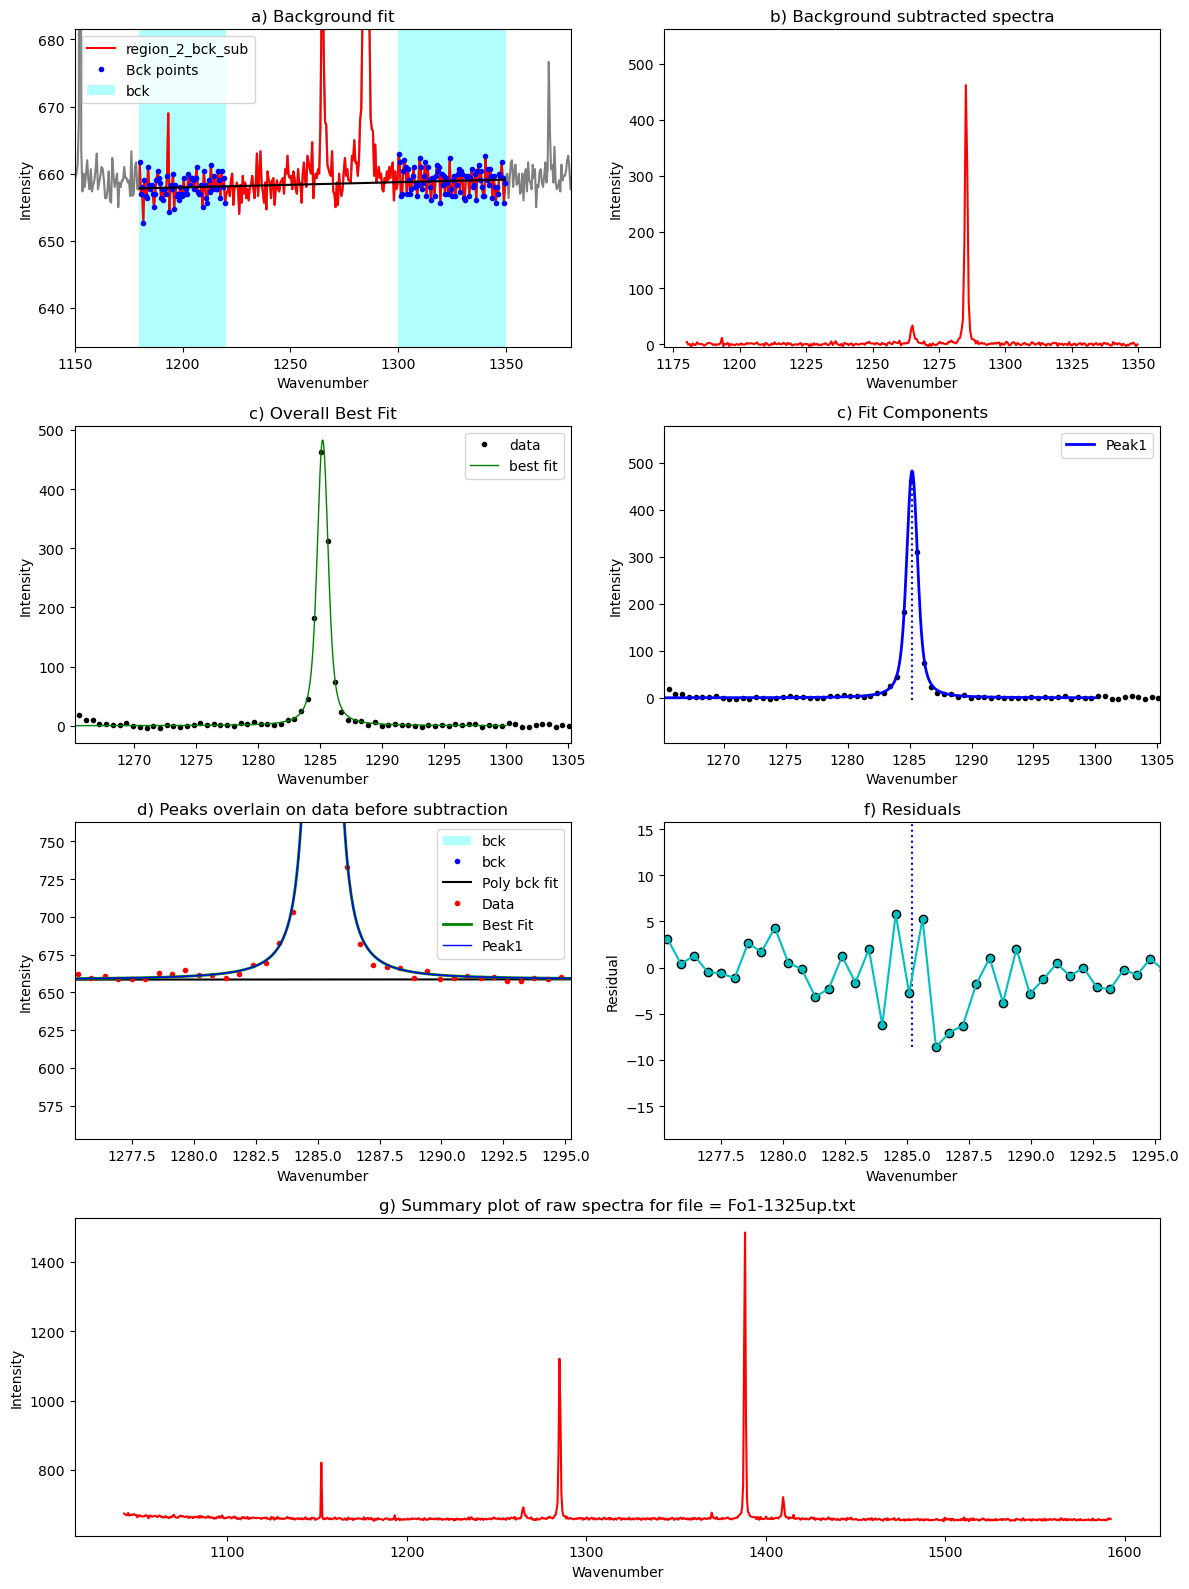

In [22]:
plot_figure=True # Means doesnt make figures, lot faster. 
save_excel=True # Saves to excel
save_clipboard=True # Copies to clipboard

df = pd.DataFrame([])
for i in range(0, len(Diad_files)):
    
    filename=Diad_files[i]
    Ne=pf.get_data(path=mypath, filename=filename, filetype=filetype)
    print('working on ' + str(Diad_files[i]))


    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config,
        config2=diad_id_config, peak_pos_voigt=diad2_peaks,
    path=mypath, filename=filename, filetype=filetype)
    
    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad1_peaks,
path=mypath, filename=filename, filetype=filetype)
    
    data=pf.combine_diad_outputs(filename=filename, prefix=prefix, 
Diad1_fit=Diad1_fit, path=mypath,
Diad2_fit=Diad2_fit)
 

    df = df.append(data)
df2=df.reset_index(drop=True)

In [24]:
df2

filename   Splitting   Diad1_Cent  Diad1_Area  Residual_Diad1  \
0  Fo1-1185down  102.920886  1285.530908  651.639693        2.570361   
1  Fo1-1200down  102.963233  1285.447966  622.764270        2.396268   
2    Fo1-1200up  102.963600  1285.444496  685.389262        2.197272   
3  Fo1-1225down  102.994166  1285.464036  603.693894        1.914520   
4    Fo1-1225up  102.895209  1285.470493  694.258591        2.230592   
5    Fo1-1250up  103.070237  1285.331978  697.026489        2.482182   
6  Fo1-1300down  103.163340  1285.308903  572.980278        2.087564   
7    Fo1-1300up  103.182796  1285.203797  735.512952        2.609046   
8  Fo1-1325down  103.204668  1285.326925  549.206712        2.117264   
9    Fo1-1325up  103.188462  1285.206293  682.494805        2.416828   

    Diad2_Cent     Diad2_Area  Residual_Diad2  HB1_Cent  HB1_Area  HB2_Cent  \
0  1388.451794     969.253392        3.306793       NaN         0       NaN   
1  1388.411199     978.701560        3.401741       NaN         0       NaN   
2  1388.408096    1076.052727        3.558656       NaN         0       NaN   
3  1388.458202     944.056331        3.362357       NaN         0       NaN   
4  1388.365702  259350.937074        4.853308       NaN         0       NaN   
5  1388.402214    1069.271017        3.734926       NaN         0       NaN   
6  1388.472243     867.525011        2.945262       NaN         0       NaN   
7  1388.386593    1114.703566        3.350824       NaN         0       NaN   
8  1388.531593     854.186250        2.994558       NaN         0       NaN   
9  1388.394756    1088.789684        3.443933       NaN         0       NaN   

   HB2_Area  C13_Cent  C13_Area  
0         0       NaN         0  
1         0       NaN         0  
2         0       NaN         0  
3         0       NaN         0  
4         0       NaN         0  
5         0       NaN         0  
6         0       NaN         0  
7         0       NaN         0  
8         0       NaN         0  
9         0       NaN         0

In [25]:
df2_filt=df2.loc[df2['Diad2_Area']<2000]

## Extracting metadata for these diads

In [26]:
meta_path=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Shifting_Window_VIBE\Metadata'
# Find files


# Put the common string you can in all your Ne lines here
ID_str='_'
file_ext_meta='txt' # Will only take files of this type 
exclude_str='Ne' # Will exclude files of this type, sometimes images have same name
prefix=None # Leave as none unless witec appended a number
Ne_files_meta=pf.get_diad_files(path=mypath, file_ext=file_ext, exclude_str='Ne',
                            exclude_str_2='ne')

Ne_files_meta


exclude type
.png


['Fo1-1185down.txt',
 'Fo1-1200down.txt',
 'Fo1-1200up.txt',
 'Fo1-1225down.txt',
 'Fo1-1225up.txt',
 'Fo1-1250up.txt',
 'Fo1-1300down.txt',
 'Fo1-1300up.txt',
 'Fo1-1325down.txt',
 'Fo1-1325up.txt']

In [27]:
meta=pf.stitch_metadata_in_loop(path=meta_path, Allfiles=Ne_files_meta, prefix=False, trupower=True)

working on fileFo1-1185down.txt
working on fileFo1-1200down.txt
working on fileFo1-1200up.txt
working on fileFo1-1225down.txt
working on fileFo1-1225up.txt
working on fileFo1-1250up.txt
working on fileFo1-1300down.txt
working on fileFo1-1300up.txt
working on fileFo1-1325down.txt
working on fileFo1-1325up.txt
Done


In [28]:
meta

filename               date  power (mW)  Int_time (s)  \
8  Fo1-1325down.txt  October 3, 2022\n      11.908          45.0   
6  Fo1-1300down.txt  October 3, 2022\n      12.000          45.0   
3  Fo1-1225down.txt  October 3, 2022\n      12.073          45.0   
1  Fo1-1200down.txt  October 3, 2022\n      12.137          45.0   
0  Fo1-1185down.txt  October 3, 2022\n      12.144          45.0   
2    Fo1-1200up.txt  October 3, 2022\n      12.145          45.0   
4    Fo1-1225up.txt  October 3, 2022\n      12.130          45.0   
5    Fo1-1250up.txt  October 3, 2022\n      12.117          45.0   
7    Fo1-1300up.txt  October 3, 2022\n      12.106          45.0   
9    Fo1-1325up.txt  October 3, 2022\n      12.119          45.0   

   accumulations  Mag (X)             duration     24hr_time  \
8            3.0     50.0  ['0h', '2m', '16s']  2:43:56 PM\n   
6            3.0     50.0  ['0h', '2m', '16s']  2:52:06 PM\n   
3            3.0     50.0  ['0h', '2m', '16s']  2:57:26 PM\n   
1            3.0     50.0  ['0h', '2m', '16s']  3:02:43 PM\n   
0            3.0     50.0  ['0h', '2m', '16s']  3:16:31 PM\n   
2            3.0     50.0  ['0h', '2m', '16s']  3:22:39 PM\n   
4            3.0     50.0  ['0h', '2m', '16s']  3:27:51 PM\n   
5            3.0     50.0  ['0h', '2m', '16s']  3:33:47 PM\n   
7            3.0     50.0  ['0h', '2m', '16s']  3:43:43 PM\n   
9            3.0     50.0  ['0h', '2m', '16s']  3:49:18 PM\n   

   sec since midnight  Spectral Center  index  
8             53036.0         1324.987      8  
6             53526.0         1299.957      6  
3             53846.0         1224.986      3  
1             54163.0         1200.009      1  
0             54991.0         1184.996      0  
2             55359.0         1200.009      2  
4             55671.0         1224.986      4  
5             56027.0         1250.004      5  
7             56623.0         1299.957      7  
9             56958.0         1324.987      9

## Stitching metadata and data together

In [29]:
meta['filename'][0]

'Fo1-1185down.txt'

In [30]:
df2['filename'][0]

'Fo1-1185down'

In [31]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'],
    prefix=False, 
    suffix=False, 
   file_type='.txt')

file_m

array(['Fo1-1325down', 'Fo1-1300down', 'Fo1-1225down', 'Fo1-1200down',
       'Fo1-1185down', 'Fo1-1200up', 'Fo1-1225up', 'Fo1-1250up',
       'Fo1-1300up', 'Fo1-1325up'], dtype=object)

In [32]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=False,
   file_type='.txt')
file_s

array(['Fo1-1185down', 'Fo1-1200down', 'Fo1-1200up', 'Fo1-1225down',
       'Fo1-1225up', 'Fo1-1250up', 'Fo1-1300down', 'Fo1-1300up',
       'Fo1-1325down', 'Fo1-1325up'], dtype=object)

In [33]:
# Combining them together
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now load in the model for doing the Ne fitting

In [45]:
from pickle import load
import pickle

pickle_path='G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Shifting_Window_VIBE'
file_pkl=pickle_path + '/' + 'Ne_Line_Regression_ExampleVIBE.pck'
with open(file_pkl, 'rb') as file_handle:
    my_loaded_model = pickle.load(file_handle)

In [46]:
df_combo['Ne_Correction']=my_loaded_model(df_combo['sec since midnight'])
df_combo['Corrected_Splitting']=df_combo['Ne_Correction']*df_combo['Splitting']

In [47]:
df_combo['Ne_Correction']

0    0.999264
1    0.999287
2    0.999070
3    0.999143
4    0.998816
5    0.998427
6    0.998913
7    0.997538
8    0.998394
9    0.996908
Name: Ne_Correction, dtype: float64

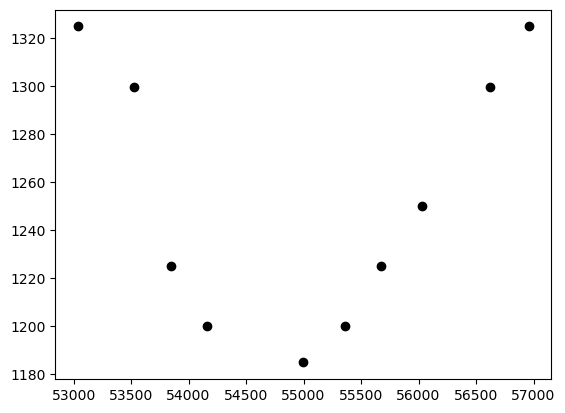

In [48]:

plt.plot(df_combo['sec since midnight'], df_combo['Spectral Center'], 'ok')

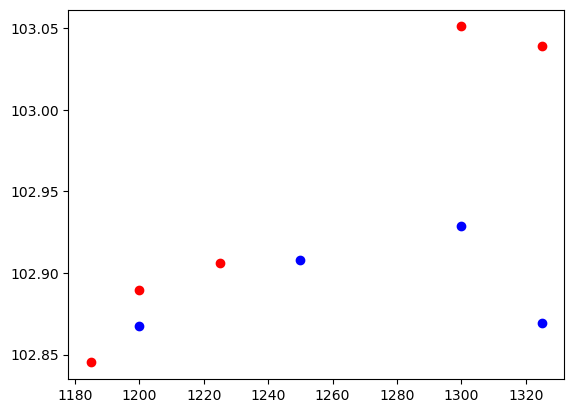

In [49]:
up=df_combo['sec since midnight']<55000
Filt=df_combo['Diad2_Area']<2000
plt.plot(df_combo['Spectral Center'].loc[Filt&up], df_combo['Corrected_Splitting'].loc[Filt&up],
           'or')
plt.plot(df_combo['Spectral Center'].loc[Filt&(~up)], df_combo['Corrected_Splitting'].loc[Filt&(~up)],
           'ob')

Text(0, 0.5, 'Splitting')

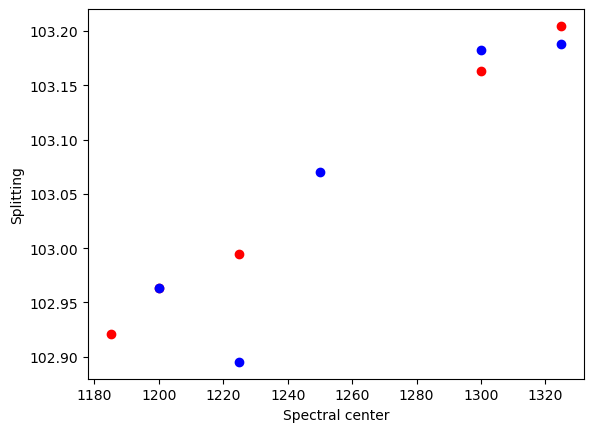

In [50]:
plt.plot(df_combo['Spectral Center'].loc[up], df_combo['Splitting'].loc[up],
           'or')
plt.plot(df_combo['Spectral Center'].loc[~up], df_combo['Splitting'].loc[~up],
           'ob')
plt.xlabel('Spectral center')
plt.ylabel('Splitting')


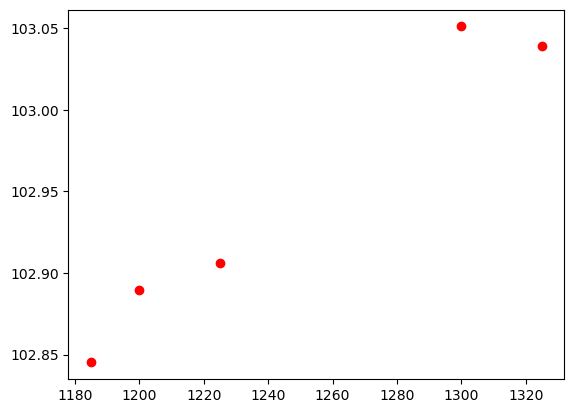

In [40]:
plt.plot(df_combo['Spectral Center'].loc[Filt&up], df_combo['Corrected_Splitting'].loc[Filt&up],
           'or')

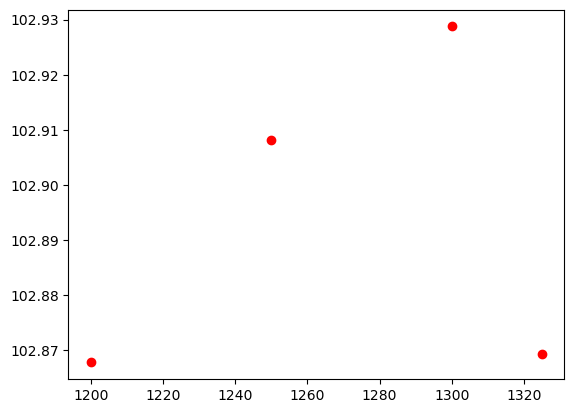

In [41]:
plt.plot(df_combo['Spectral Center'].loc[Filt&(~up)], df_combo['Corrected_Splitting'].loc[Filt&(~up)],
           'or')

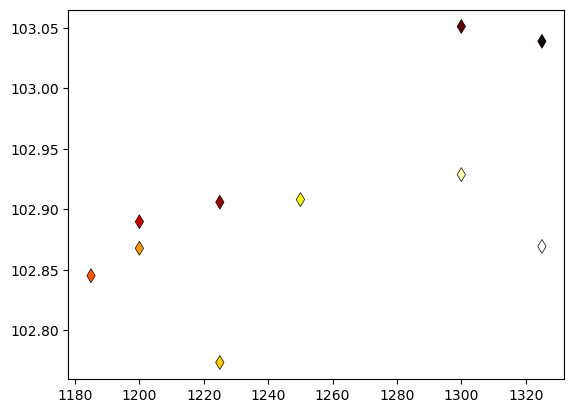

In [40]:
plt.scatter(df_combo['Spectral Center'], df_combo['Corrected_Splitting'],
            marker='d', s=50, edgecolors='k', linewidths=0.5,
             cmap='hot',
            c=df_combo['sec since midnight'])

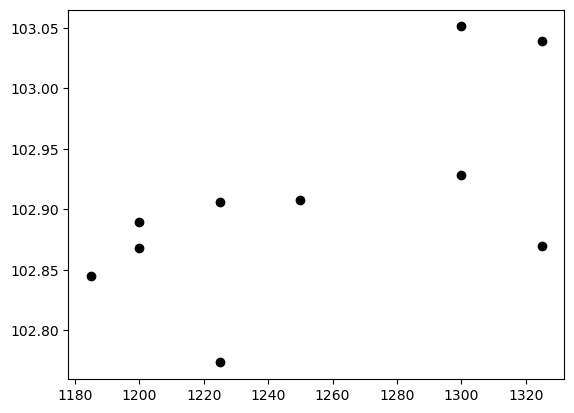

In [41]:
plt.plot(df_combo['Spectral Center'], df_combo['Corrected_Splitting'], 'ok')